In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import calendar
import time
from matplotlib import colors
from sklearn import preprocessing
import cartopy.crs as crs
import cartopy.feature as cfeature

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_model_rmse_months_clim_divs(
    model, fcast_and_error_df, max_fhour, var, units, minmax
):
    fcast_and_error_df = fcast_and_error_df.copy()
    fcast_and_error_df = fcast_and_error_df[
        fcast_and_error_df["lead_time_ONLY_HOURS"] <= max_fhour
    ]
    fcast_and_error_df[f"{var}_sq"] = fcast_and_error_df[var] ** 2
    rmse_months = (
        fcast_and_error_df.groupby([fcast_and_error_df.time.dt.month, "station"])[
            f"{var}_sq"
        ]
        .mean()
        .apply(np.sqrt)
    )
    rmse_months_stns = (
        fcast_and_error_df.groupby([fcast_and_error_df.time.dt.month, "station"])[
            f"{var}_sq"
        ]
        .mean()
        .apply(np.sqrt)
    )
    rmse_stns = (
        fcast_and_error_df.groupby(["station"])[f"{var}_sq"].mean().apply(np.sqrt)
    )

    new_column_order = [
        "Coastal",
        "Champlain Valley",
        "St. Lawrence Valley",
        "Hudson Valley",
        "Great Lakes",
        "Mohawk Valley",
        "Central Lakes",
        "Eastern Plateau",
        "Northern Plateau",
        "Western Plateau",
    ]
    return rmse_months, rmse_stns, rmse_months_stns


def get_monthly_rmse_data(fhour_end, var):
    (
        gfs_rmse_months,
        gfs_rmse_stns,
        gfs_rmse_months_stns,
    ) = get_model_rmse_months_clim_divs(
        "GFS",
        gfs_fcast_and_error_df,
        fhour_end,
        var,
        var_dict.get(var),
        var_val_range.get(var),
    )
    (
        nam_rmse_months,
        nam_rmse_stns,
        nam_rmse_months_stns,
    ) = get_model_rmse_months_clim_divs(
        "NAM",
        nam_fcast_and_error_df,
        fhour_end,
        var,
        var_dict.get(var),
        var_val_range.get(var),
    )

    gfs_rmse_months = gfs_rmse_months.reset_index()
    nam_rmse_months = nam_rmse_months.reset_index()

    gfs_rmse_months["NWP Model"] = "GFS"
    nam_rmse_months["NWP Model"] = "NAM"

    print("GFS", gfs_rmse_months[f"{var}_sq"].mean())
    print("NAM", nam_rmse_months[f"{var}_sq"].mean())

    if fhour_end <= 18:
        (
            hrrr_rmse_months,
            hrrr_rmse_stns,
            hrrr_rmse_months_stns,
        ) = get_model_rmse_months_clim_divs(
            "HRRR",
            hrrr_fcast_and_error_df,
            fhour_end,
            var,
            var_dict.get(var),
            var_val_range.get(var),
        )
        hrrr_rmse_months = hrrr_rmse_months.reset_index()
        hrrr_rmse_months["NWP Model"] = "HRRR"
        print("HRRR", hrrr_rmse_months[f"{var}_sq"].mean())
        rmse_to_plot = pd.concat([gfs_rmse_months, nam_rmse_months, hrrr_rmse_months])
    else:
        rmse_to_plot = pd.concat([gfs_rmse_months, nam_rmse_months])

    return rmse_to_plot


def plot_rmse_boxplots(df, fhour_end, var):
    rmse_to_plot = df
    palette_DJF = {"GFS": "dodgerblue", "NAM": "dodgerblue", "HRRR": "dodgerblue"}
    palette_MAM = {"GFS": "darkorchid", "NAM": "darkorchid", "HRRR": "darkorchid"}
    palette_JJA = {"GFS": "darkgreen", "NAM": "darkgreen", "HRRR": "darkgreen"}
    palette_SON = {"GFS": "coral", "NAM": "coral", "HRRR": "coral"}
    h_ind = 3
    if fhour_end > 18:
        palette_DJF.pop("HRRR", None)
        palette_MAM.pop("HRRR", None)
        palette_JJA.pop("HRRR", None)
        palette_SON.pop("HRRR", None)
        h_ind = h_ind - 1

    plt.figure(figsize=(12, 5), dpi=100)
    ax = sns.boxplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot,
        hue="NWP Model",
        width=0.7,
        zorder=4,
        palette="binary",
        medianprops=dict(color="white"),
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([12, 1, 2])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_DJF,
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([3, 4, 5])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_MAM,
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([6, 7, 8])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_JJA,
    )
    sns.stripplot(
        x="station",
        y=f"{var}_sq",
        data=rmse_to_plot[rmse_to_plot["time"].isin([9, 10, 11])],
        hue="NWP Model",
        size=5,
        dodge=True,
        zorder=5,
        palette=palette_SON,
    )
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(
        handles[0:h_ind] + handles[h_ind::h_ind],
        labels[0:h_ind] + ["DJF", "MAM", "JJA", "SON"],
        loc=2,
        borderaxespad=0.0,
    )
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.4, zorder=1)
    plt.ylabel(f"RMSE t2m_error")
    plt.ylim(ymax=4.0, ymin=1.0)
    plt.xlabel("Station")
    plt.tight_layout()

In [3]:
def read_data(init):
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [4]:
def err_plot(df, month, up):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["t2m_error_sq"],
        s=df["t2m_error_sq"] * 50,
        marker="o",
        edgecolor="black",
        cmap="jet",
        transform=crs.PlateCarree(),
    )
    titl_Str = f"t2m_Forecast Error {up} {month}"
    ax.set_title(titl_Str, size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()
    fig.colorbar(plotter, ax=ax)

In [5]:
def count_plot(tops, bottoms, month):
    projPC = crs.PlateCarree()
    latN = 45.5
    latS = 40
    lonW = -80
    lonE = -71.5
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=tops["lon"],
        y=tops["lat"],
        c="g",
        s=50,
        marker="v",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    plotter2 = ax.scatter(
        x=bottoms["lon"],
        y=bottoms["lat"],
        c="orange",
        s=50,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Best/Worst Sites by Error {month}", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [6]:
def count_plot_top(df):
    projPC = crs.PlateCarree()
    latN = 45.5
    latS = 40
    lonW = -80
    lonE = -71.5
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c="g",
        s=50,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Top 10% Sites by t2m Error", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [7]:
def count_plot_bott(df):
    projPC = crs.PlateCarree()
    latN = 45.5
    latS = 40
    lonW = -80
    lonE = -71.5
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    plotter = ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c="r",
        s=50,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Bottom 10% Sites by t2m Error", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [8]:
def plot_model_rmse_heatmap_fhours_clim_divs(
    model, fcast_and_error_df, var, units, minmax, stations
):
    fcast_and_error_df = fcast_and_error_df.copy()
    fcast_and_error_df[f"{var}_sq"] = fcast_and_error_df[var] ** 2
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["t2m_error_sq"] <= 18]
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["lead_time_HOUR"] < 25]
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["lead_time_HOUR"] != 0]
    fcast_and_error_df = fcast_and_error_df[fcast_and_error_df["lead_time_DAY"] == 0]
    rmse = (
        fcast_and_error_df.groupby(["lead_time_HOUR", "station"])[f"{var}_sq"]
        .mean()
        .apply(np.sqrt)
    )

    rmse_unstacked = rmse.unstack()[stations].T
    rmse_unstacked = rmse_unstacked.drop_duplicates()
    plt.figure(figsize=(20, 5))
    ax = sns.heatmap(
        rmse_unstacked,
        annot=True,
        linewidths=0.5,
        cmap=cm.YlGnBu,
        vmin=minmax[0],
        vmax=minmax[1],
        cbar_kws={"label": f"RMSE [{units}]"},
    )
    ax.set_xlabel("Forecast Hour")
    ax.set_title(f"{model}, {var.replace('_error','')}, Root Mean Square Error")
    plt.tight_layout()

In [9]:
def format_plot_df(tippity_df, keys):
    plot_df = pd.DataFrame()
    stat_ls = []
    lat_ls = []
    lon_ls = []
    for i, _ in enumerate(tippity_df["station"]):
        if tippity_df["station"].iloc[i] in keys:
            stations = tippity_df["station"].iloc[i]
            lats = tippity_df["lat"].iloc[i]
            lons = tippity_df["lon"].iloc[i]
            stat_ls.append(stations)
            lat_ls.append(lats)
            lon_ls.append(lons)
    plot_df["stations"] = stat_ls
    plot_df["lat"] = lat_ls
    plot_df["lon"] = lon_ls

    return plot_df

In [73]:
var_dict = {
    "d2m_error": "$^{\circ}$C",
    "u_dir_error": "$^{\circ}$",
    "u_total_error": "m s$^{-1}$",
    "t2m_error": "$^{\circ}$C",
    "new_tp_error": "mm",
    "prmsl_error": "hPa",
}

var_val_range = {
    "d2m_error": [1.0, 4.0],
    "u_dir_error": [40, 100],
    "u_total_error": [1, 3.5],
    "t2m_error": [1.0, 3.5],
    "new_tp_error": [0, 3.5],
    "prmsl_error": [-20, 100],
}

In [11]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [12]:
gfs_fcast_and_error_df.head()

station          valid_time                time    t2m_GFS    d2m_GFS  \
0    ADDI 2018-01-01 15:00:00 2018-01-01 12:00:00 -15.349532 -20.611755   
1    ADDI 2018-01-01 18:00:00 2018-01-01 12:00:00 -11.786198 -18.275512   
2    ADDI 2018-01-01 21:00:00 2018-01-01 12:00:00 -12.116852 -17.688393   
3    ADDI 2018-01-02 00:00:00 2018-01-01 12:00:00 -14.021501 -18.160225   
4    ADDI 2018-01-02 03:00:00 2018-01-01 12:00:00 -12.497983 -15.941133   

   u_total_GFS   u_dir_GFS   latitude  longitude  new_tp_GFS  ...  \
0     2.655496  288.477132  42.040359 -77.237259    0.000000  ...   
1     5.396916  285.354245  42.040359 -77.237259    0.005045  ...   
2     5.713116  286.574791  42.040359 -77.237259    0.024612  ...   
3     5.958310  273.989092  42.040359 -77.237259    0.010090  ...   
4     5.731337  300.191211  42.040359 -77.237259    0.140135  ...   

   prmsl_error   t2m_nysm   d2m_nysm  u_total_nysm  u_dir_nysm  new_tp_nysm  \
0    66.532533 -16.211229 -20.564865      1.854602  260.777710     0.000000   
1    66.223569 -12.779670 -18.921921      4.014196  244.369293     0.000000   
2    65.764059 -12.434510 -16.971771      2.923199  307.399109     0.000000   
3    65.920914 -13.972590 -19.079498      2.254292  282.835999     0.149994   
4    66.428000 -13.941200 -16.723541      2.284459  282.010406     0.000000   

   prmsl_nysm  lead_time_DAY  lead_time_HOUR  lead_time_ONLY_HOURS  
0  965.472778              0               3                   3.0  
1  963.408386              0               6                   6.0  
2  962.831970              0               9                   9.0  
3  963.546021              0              12                  12.0  
4  963.969604              0              15                  15.0  

[5 rows x 27 columns]

In [72]:
gfs_fcast_and_error_df.keys()

Index(['station', 'valid_time', 'time', 't2m_GFS', 'd2m_GFS', 'u_total_GFS',
       'u_dir_GFS', 'latitude', 'longitude', 'new_tp_GFS', 'prmsl_GFS', 'orog',
       't2m_error', 'd2m_error', 'u_total_error', 'u_dir_error',
       'new_tp_error', 'prmsl_error', 't2m_nysm', 'd2m_nysm', 'u_total_nysm',
       'u_dir_nysm', 'new_tp_nysm', 'prmsl_nysm', 'lead_time_DAY',
       'lead_time_HOUR', 'lead_time_ONLY_HOURS'],
      dtype='object')

In [13]:
rmse_to_plot = get_monthly_rmse_data(18, "t2m_error")

GFS 1.9642531135956658
NAM 1.8713559231397245
HRRR 2.1093853


In [14]:
rmse_to_plot = rmse_to_plot.sort_values(by=["t2m_error_sq"])
rmse_to_plot

time station  t2m_error_sq NWP Model
1218    10    QUEE      1.080360       NAM
104      1    STON      1.112473       NAM
1092     9    QUEE      1.136234       NAM
1143    10    BKLN      1.143872       NAM
1146    10    BROC      1.178534      HRRR
...    ...     ...           ...       ...
118      1    WBOU      3.820185      HRRR
240      2    WANT      4.072396      HRRR
493      4    WARS      4.118878      HRRR
114      1    WANT      4.205935      HRRR
1374    11    WANT      4.291911      HRRR

[4536 rows x 4 columns]

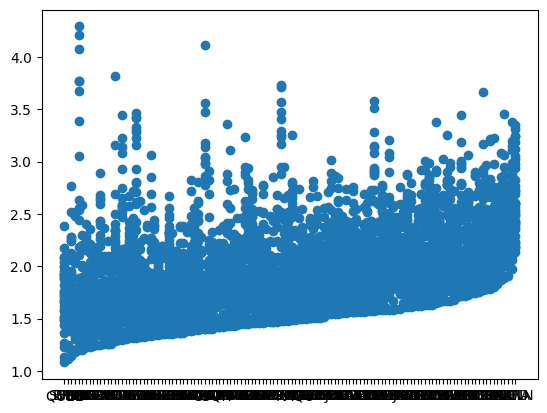

In [15]:
plt.scatter(rmse_to_plot["station"], rmse_to_plot["t2m_error_sq"])

In [16]:
rmse_to_plot["t2m_error_sq"].describe()

count    4536.000000
mean        1.981665
std         0.394360
min         1.080360
25%         1.706307
50%         1.922406
75%         2.196558
max         4.291911
Name: t2m_error_sq, dtype: float64

In [17]:
diction = pd.read_csv("/home/aevans/landtype/notebooks/nysm_coords.csv")

In [18]:
ny_stations = diction["station"]
ny_lats = diction["latitude"]
ny_lons = diction["longitude"]

In [19]:
latdict = dict(zip(diction.station, diction.latitude))
londict = dict(zip(diction.station, diction.longitude))

In [20]:
rmse_to_plot["lon"] = rmse_to_plot["station"].map(londict)
rmse_to_plot["lat"] = rmse_to_plot["station"].map(latdict)

In [21]:
rmse_to_plot

time station  t2m_error_sq NWP Model        lon        lat
1218    10    QUEE      1.080360       NAM -73.815857  40.734337
104      1    STON      1.112473       NAM -73.131683  40.919121
1092     9    QUEE      1.136234       NAM -73.815857  40.734337
1143    10    BKLN      1.143872       NAM -73.953674  40.631763
1146    10    BROC      1.178534      HRRR -77.965919  43.208351
...    ...     ...           ...       ...        ...        ...
118      1    WBOU      3.820185      HRRR -74.588333  41.745049
240      2    WANT      4.072396      HRRR -73.506157  40.655102
493      4    WARS      4.118878      HRRR -78.208893  42.779930
114      1    WANT      4.205935      HRRR -73.506157  40.655102
1374    11    WANT      4.291911      HRRR -73.506157  40.655102

[4536 rows x 6 columns]

In [22]:
nysm_df = rmse_to_plot[rmse_to_plot['time']==1]

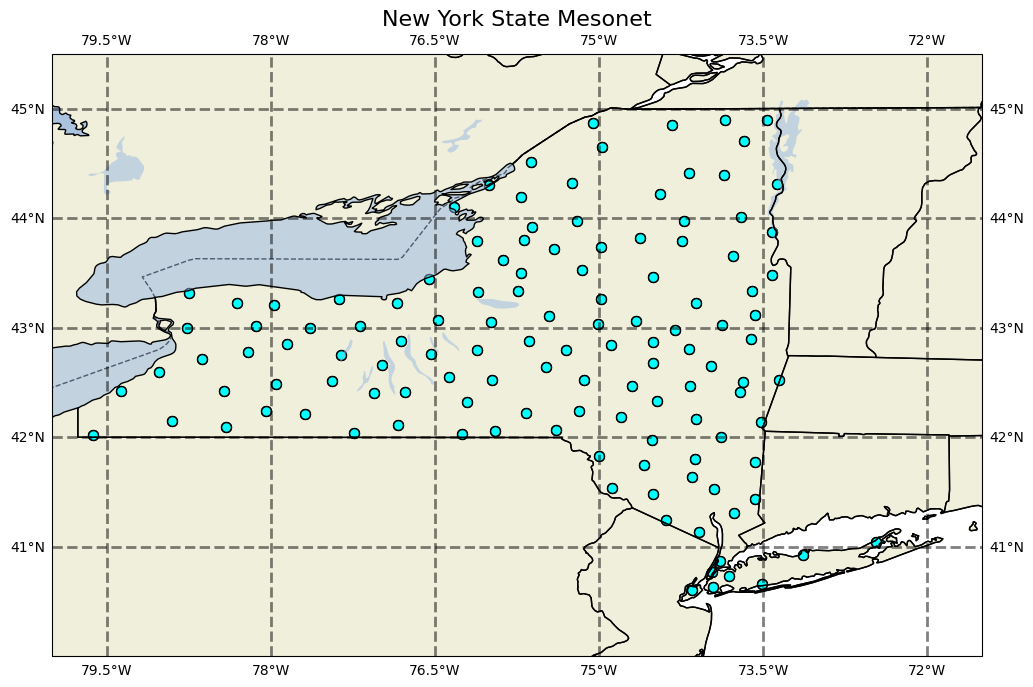

In [23]:
projPC = crs.PlateCarree()
latN = 45.5
latS = 40
lonW = -80
lonE = -71.5
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

fig, ax = plt.subplots(
    figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}
)
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle="--")
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.STATES)
ax.xticklabels_top = False
ax.ylabels_right = False
ax.gridlines(
    crs=crs.PlateCarree(),
    draw_labels=True,
    linewidth=2,
    color="black",
    alpha=0.5,
    linestyle="--",
)
plotter = ax.scatter(
    x=nysm_df["lon"],
    y=nysm_df["lat"],
    c="cyan",
    s=50,
    marker="o",
    edgecolor="black",
    transform=crs.PlateCarree(),
)
ax.set_title(f"New York State Mesonet", size=16)
ax.set_xlabel("Longitude", size=14)
ax.set_ylabel("Latitude", size=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid()

In [24]:
rmse_hrrr = rmse_to_plot[rmse_to_plot["NWP Model"] == "HRRR"]
rmse_hrrr

time station  t2m_error_sq NWP Model        lon        lat
1146    10    BROC      1.178534      HRRR -77.965919  43.208351
104      1    STON      1.220651      HRRR -73.131683  40.919121
351      3    SOUT      1.255930      HRRR -72.465866  41.040081
225      2    SOUT      1.281439      HRRR -72.465866  41.040081
1230    10    SCIP      1.292173      HRRR -76.534035  42.756214
...    ...     ...           ...       ...        ...        ...
118      1    WBOU      3.820185      HRRR -74.588333  41.745049
240      2    WANT      4.072396      HRRR -73.506157  40.655102
493      4    WARS      4.118878      HRRR -78.208893  42.779930
114      1    WANT      4.205935      HRRR -73.506157  40.655102
1374    11    WANT      4.291911      HRRR -73.506157  40.655102

[1512 rows x 6 columns]

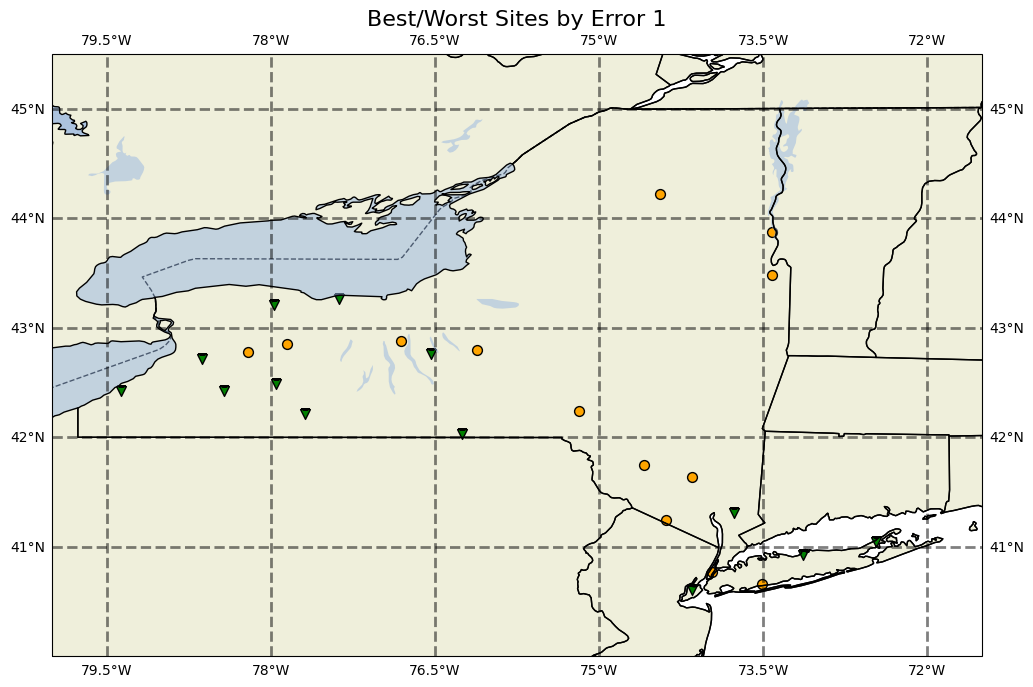

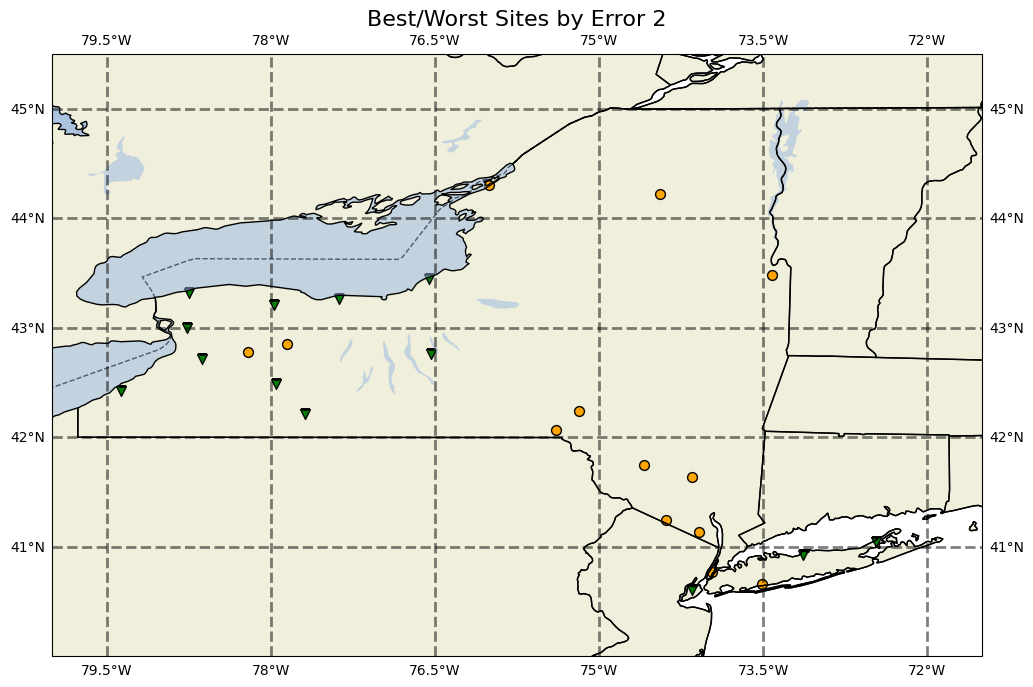

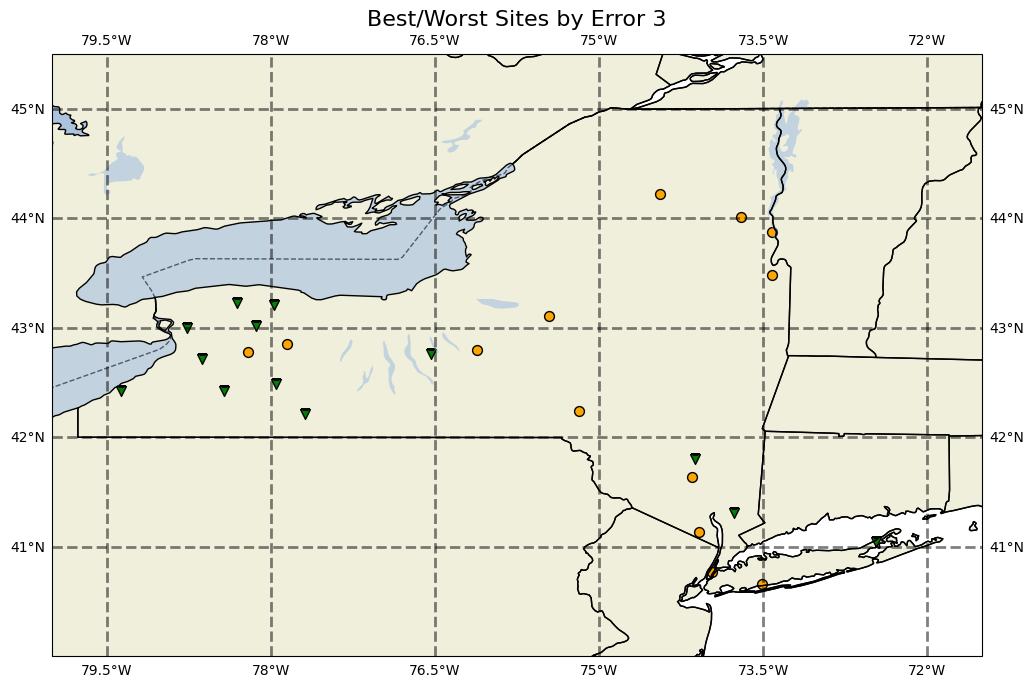

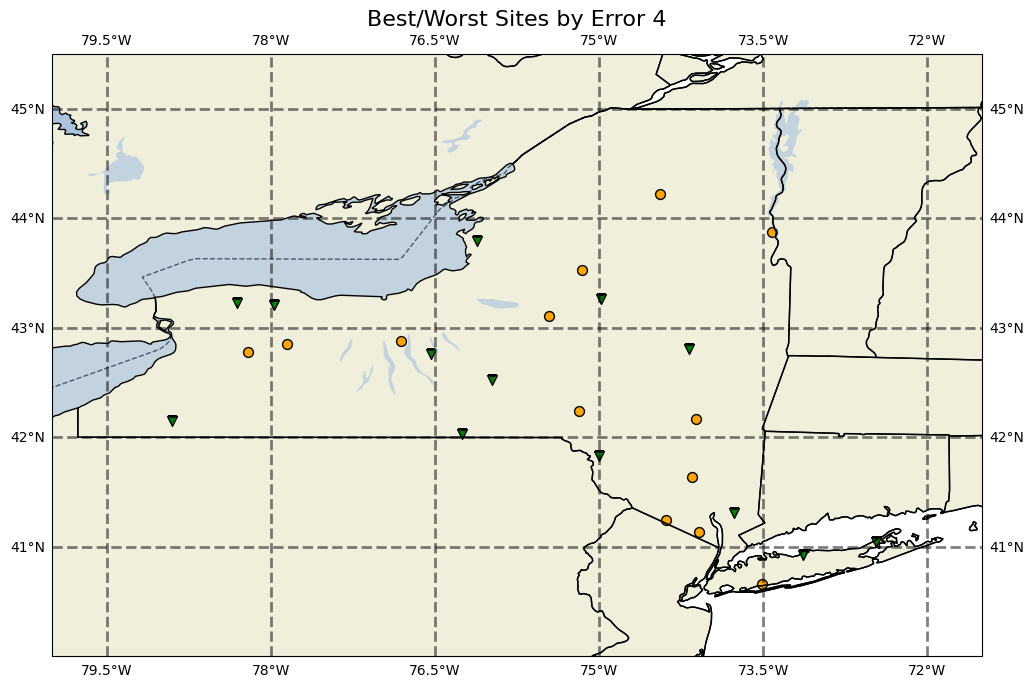

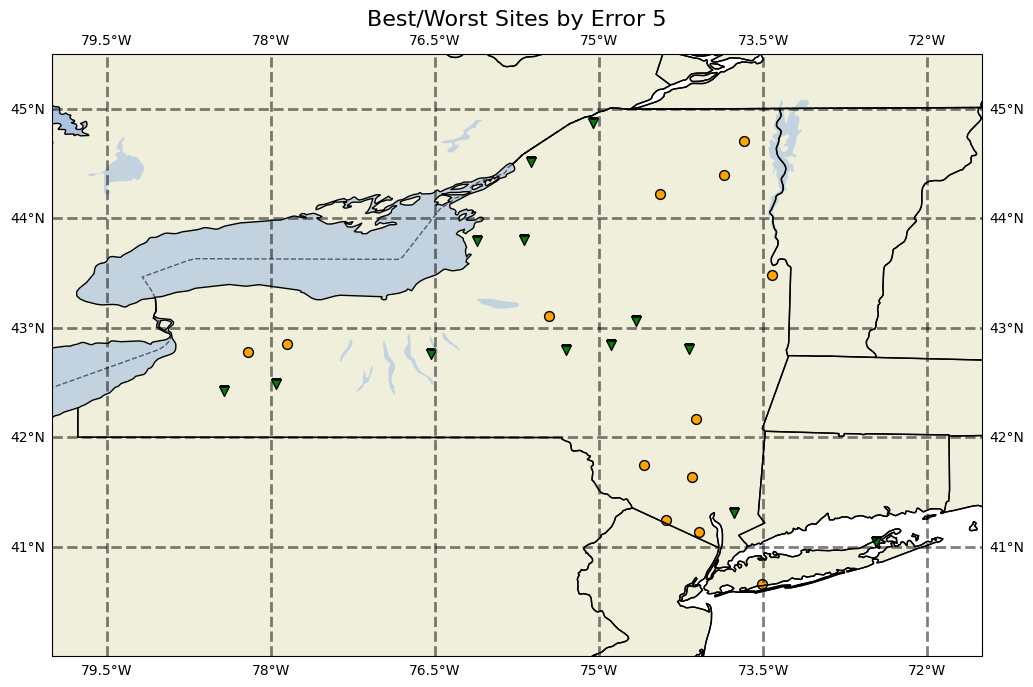

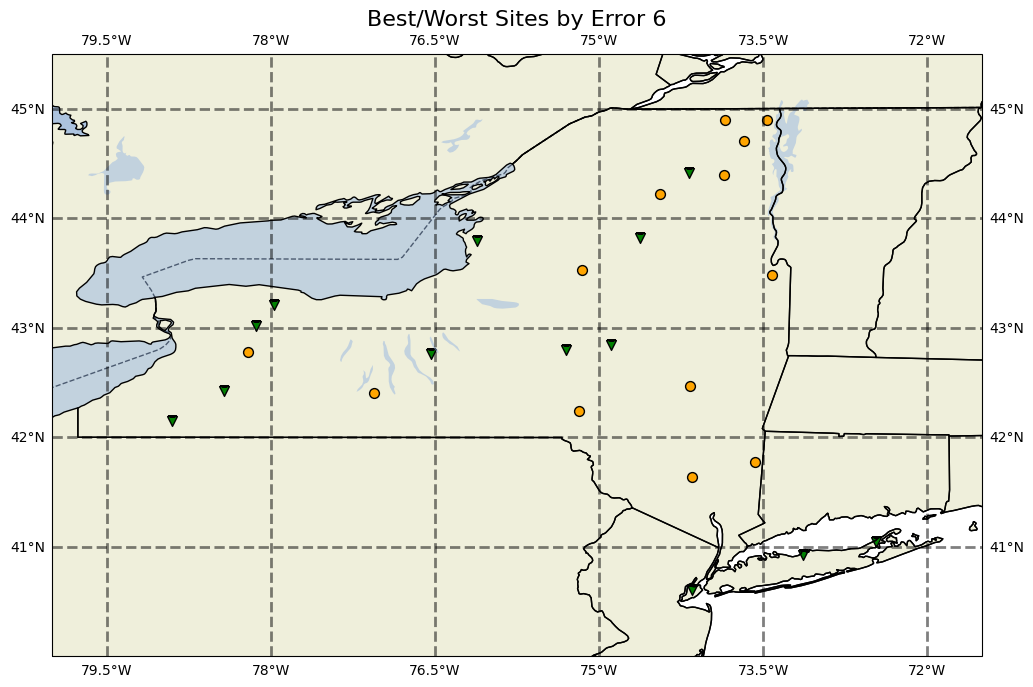

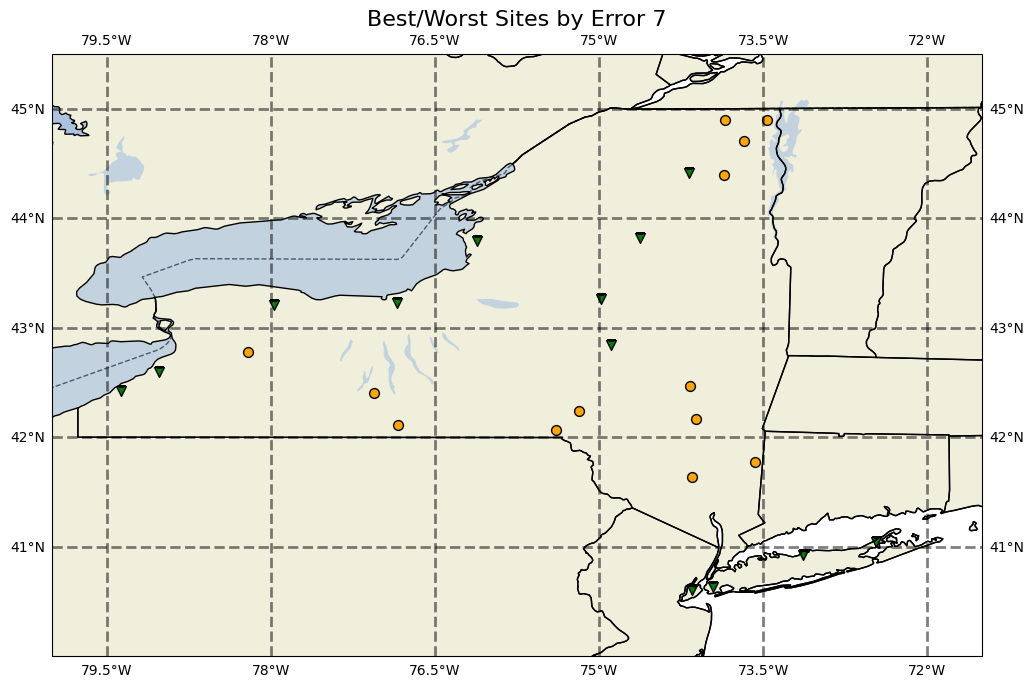

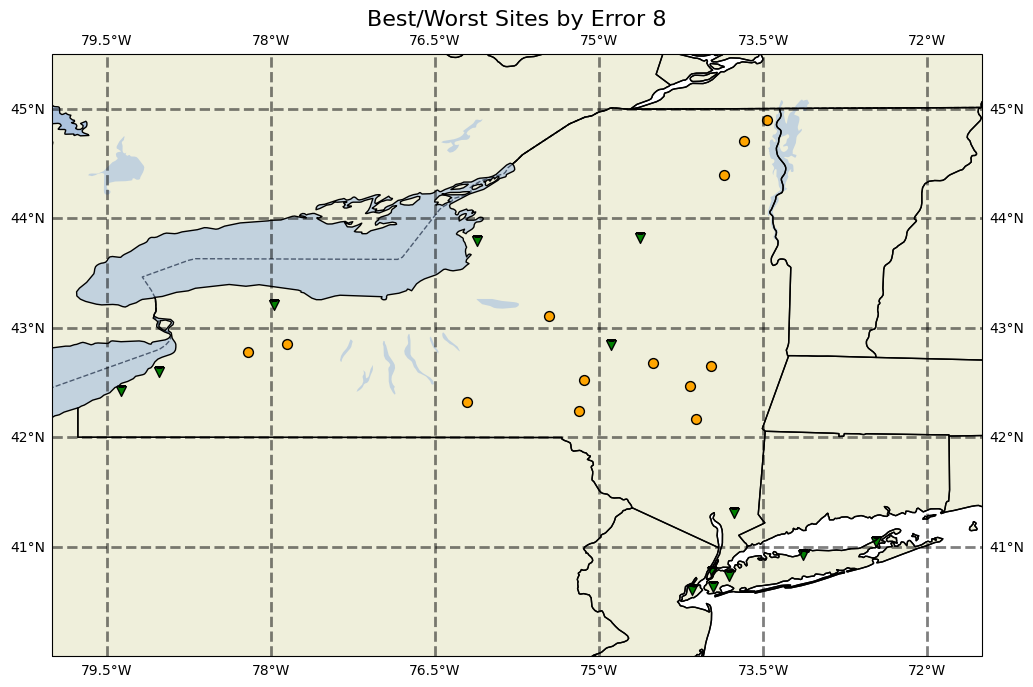

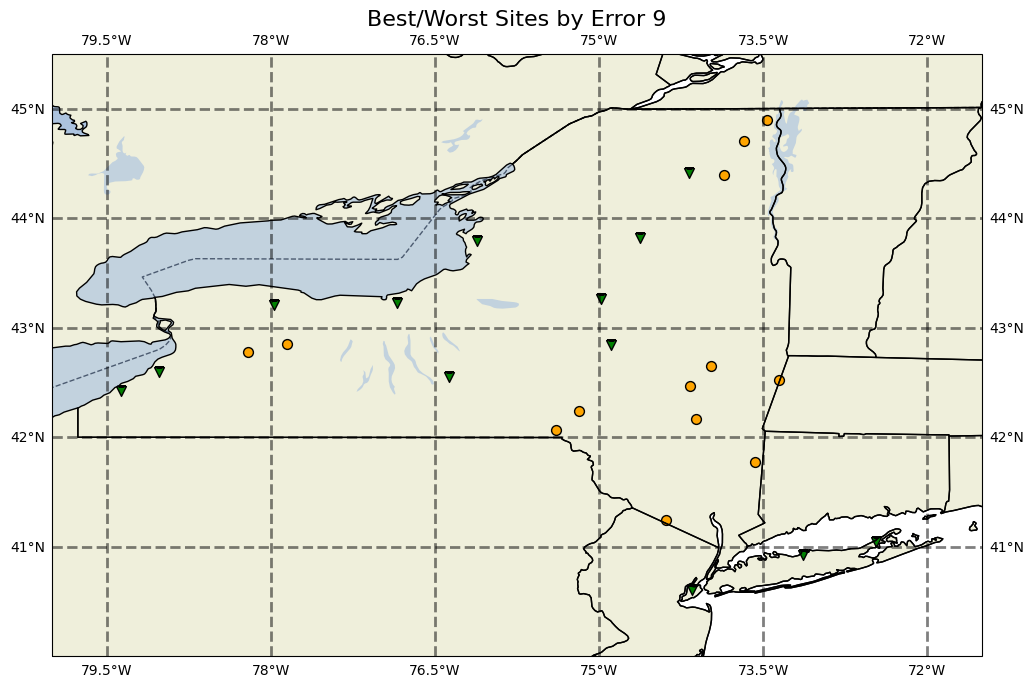

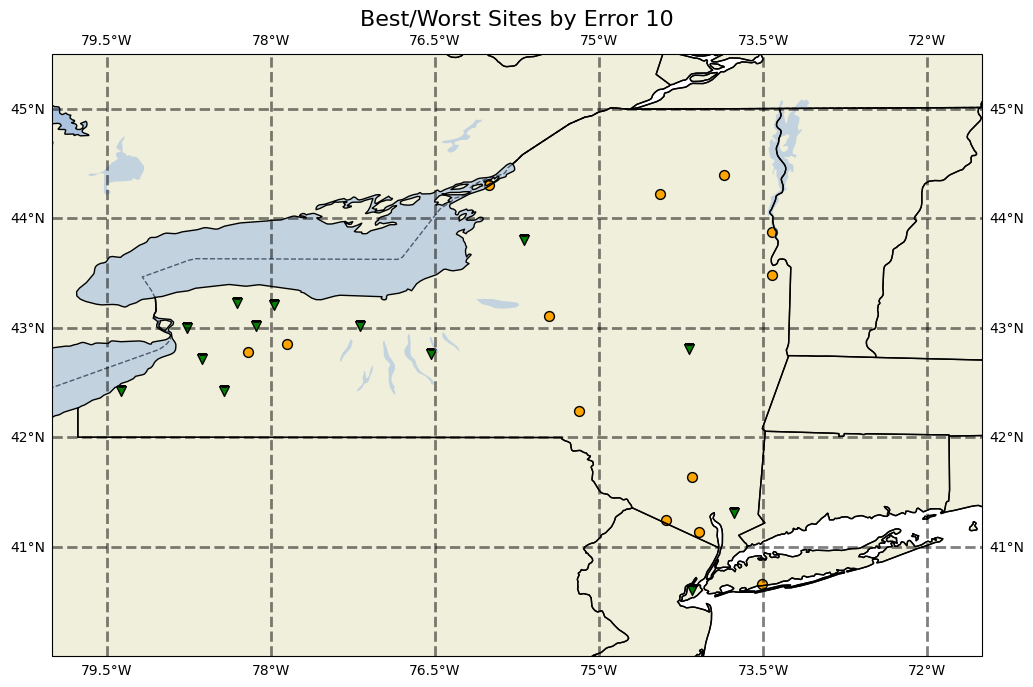

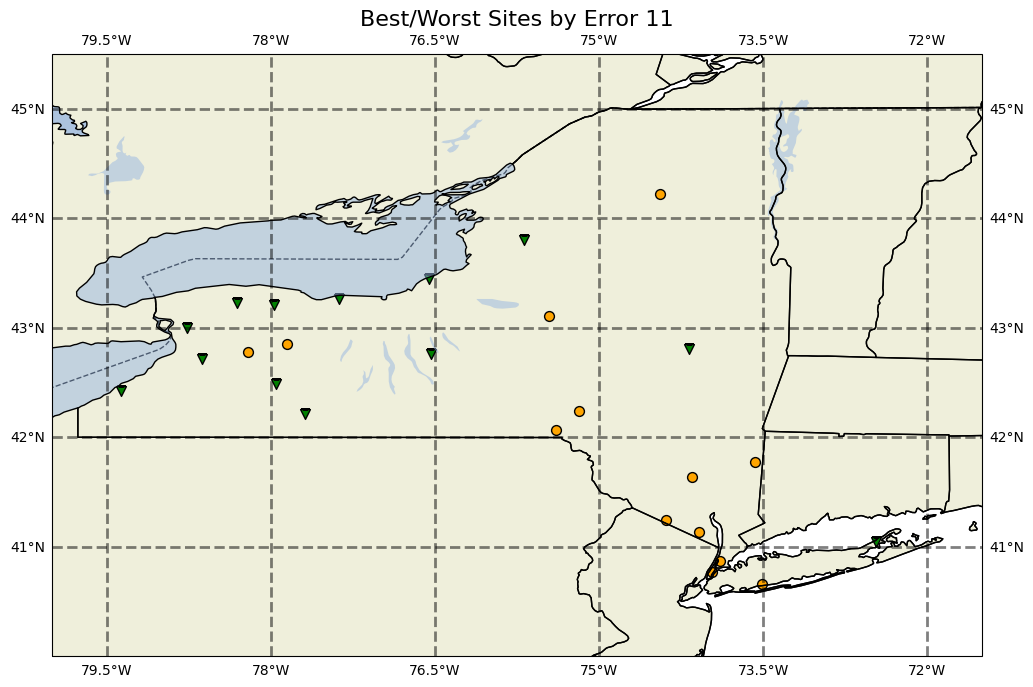

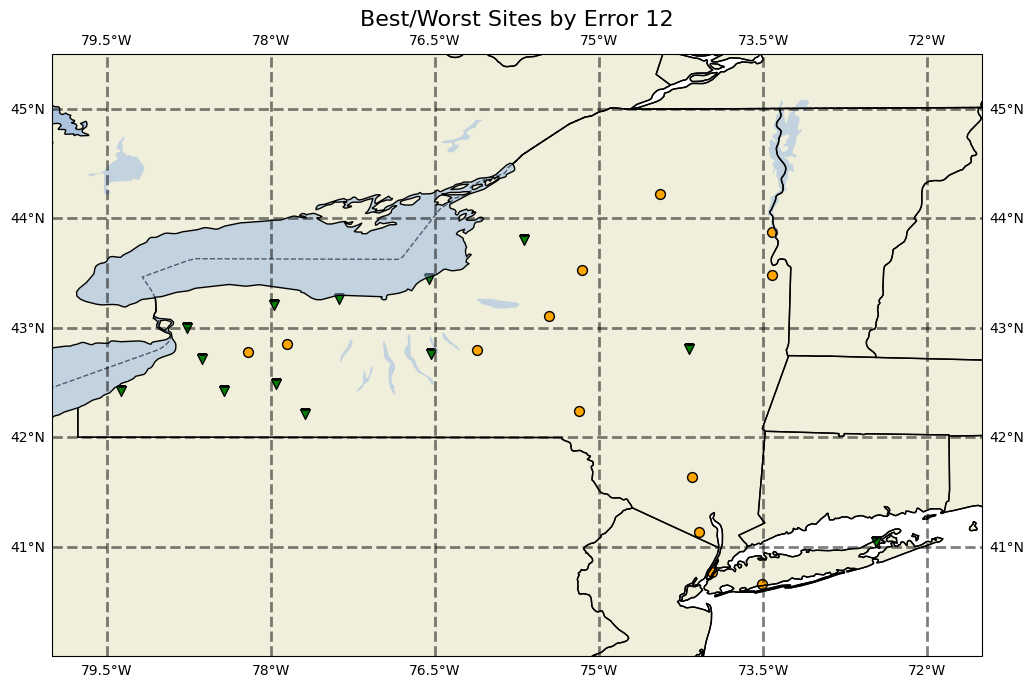

In [25]:
tops_ls = []
bottoms_ls = []


for i in np.arange(1, 13):
    # sort by month
    df_err = rmse_hrrr.where(rmse_hrrr["time"] == i).dropna()

    # get top and bottom
    top10 = df_err[:13]
    bottom10 = df_err[-13:]
    top10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_hrrr.csv"
    )
    bottom10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_hrrr.csv"
    )

    # plot
    count_plot(top10, bottom10, i)

In [26]:
tippity_df = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_hrrr.csv"
    )
    tippity_df = pd.concat([df, tippity_df])

In [27]:
rockbott_df = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_hrrr.csv"
    )
    rockbott_df = pd.concat([df, rockbott_df])

In [28]:
rockbott_df

Unnamed: 0  time station  t2m_error_sq NWP Model        lon        lat
0         1493  12.0    TICO      2.471293      HRRR -73.418793  43.874691
1         1508  12.0    WGAT      2.522988      HRRR -75.158600  43.532410
2         1506  12.0    WEST      2.674097      HRRR -75.461456  43.106468
3         1498  12.0    WALL      2.676454      HRRR -74.153702  41.634090
4         1511  12.0    YORK      2.727689      HRRR -77.847763  42.855042
..         ...   ...     ...           ...       ...        ...        ...
8          115   1.0    WARS      3.476376      HRRR -78.208893  42.779930
9          125   1.0    YORK      3.576507      HRRR -77.847763  42.855042
10         113   1.0    WALT      3.713519      HRRR -75.178787  42.239498
11         118   1.0    WBOU      3.820185      HRRR -74.588333  41.745049
12         114   1.0    WANT      4.205935      HRRR -73.506157  40.655102

[156 rows x 7 columns]

In [29]:
keys = tippity_df["station"].value_counts()[:13].keys()
keys

Index(['BROC', 'SOUT', 'FRED', 'SCIP', 'STON', 'STAT', 'DELE', 'GROV', 'EAUR',
       'BELL', 'SOME', 'SPRI', 'HART'],
      dtype='object')

In [30]:
plot_df = pd.DataFrame()
stat_ls = []
lat_ls = []
lon_ls = []
for i, _ in enumerate(tippity_df["station"]):
    if tippity_df["station"].iloc[i] in keys:
        stations = tippity_df["station"].iloc[i]
        lats = tippity_df["lat"].iloc[i]
        lons = tippity_df["lon"].iloc[i]
        stat_ls.append(stations)
        lat_ls.append(lats)
        lon_ls.append(lons)
plot_df["stations"] = stat_ls
plot_df["lat"] = lat_ls
plot_df["lon"] = lon_ls

In [31]:
keys = rockbott_df["station"].value_counts()[:13].keys()
keys

Index(['WARS', 'WALT', 'WALL', 'YORK', 'TUPP', 'WANT', 'WARW', 'WEST', 'WHIT',
       'SUFF', 'WFMB', 'TANN', 'TICO'],
      dtype='object')

In [32]:
plot_df_bott = format_plot_df(rockbott_df, keys)

In [33]:
plot_df_bott

stations        lat        lon
0       TICO  43.874691 -73.418793
1       WEST  43.106468 -75.461456
2       WALL  41.634090 -74.153702
3       YORK  42.855042 -77.847763
4       WARS  42.779930 -78.208893
..       ...        ...        ...
99      WALL  41.634090 -74.153702
100     WARS  42.779930 -78.208893
101     YORK  42.855042 -77.847763
102     WALT  42.239498 -75.178787
103     WANT  40.655102 -73.506157

[104 rows x 3 columns]

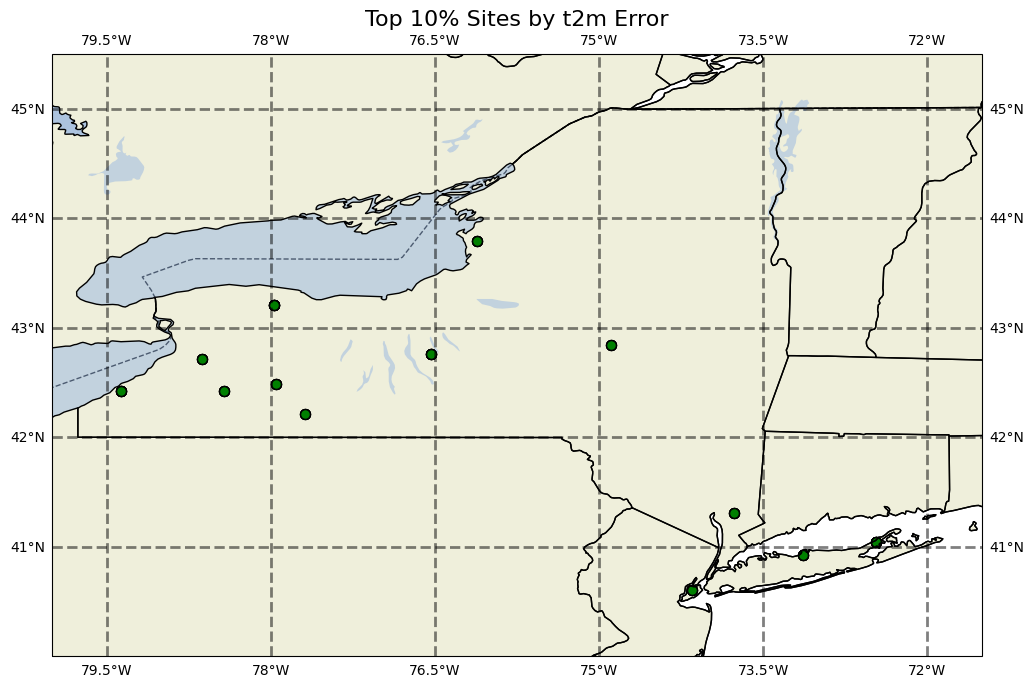

In [34]:
count_plot_top(plot_df)

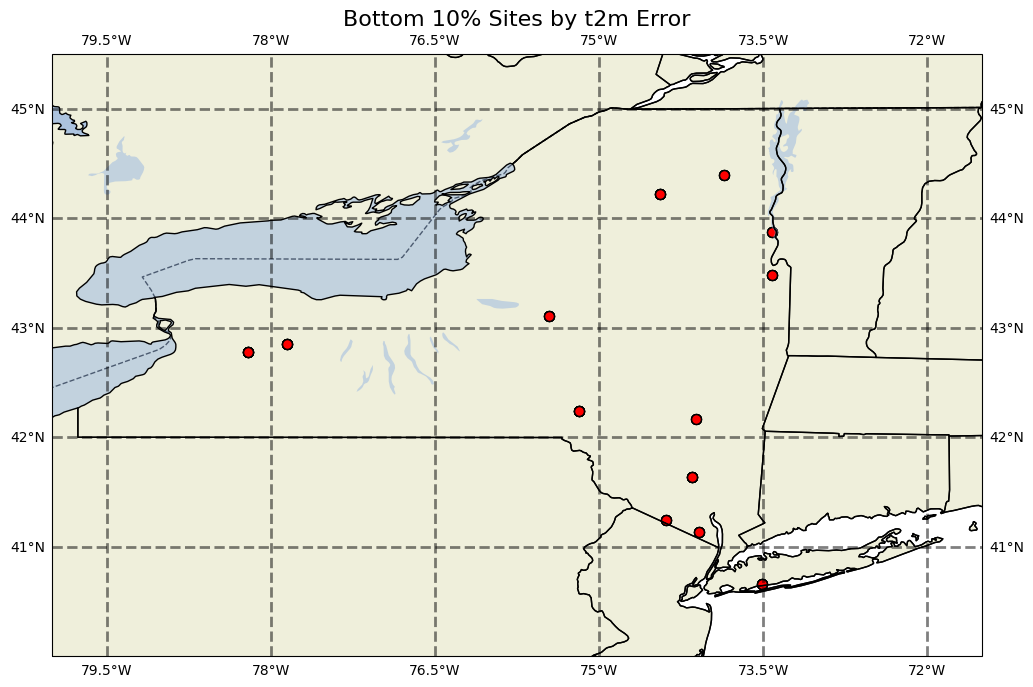

In [35]:
count_plot_bott(plot_df_bott)

# GFS

In [36]:
rmse_gfs = rmse_to_plot[rmse_to_plot["NWP Model"] == "GFS"]
rmse_gfs

time station  t2m_error_sq NWP Model        lon        lat
1362    11    STAT      1.201278       GFS -74.148499  40.604015
1344    11    QUEE      1.232478       GFS -73.815857  40.734337
1147    10    BRON      1.237043       GFS -73.893524  40.872482
1273    11    BRON      1.243990       GFS -73.893524  40.872482
1159    10    CLIF      1.245621       GFS -77.185181  43.014790
...    ...     ...           ...       ...        ...        ...
736      6    TANN      3.021715       GFS -74.113426  42.170712
862      7    TANN      3.184860       GFS -74.113426  42.170712
598      5    SCHO      3.240039       GFS -73.685837  42.506310
191      2    MANH      3.288012       GFS -73.964485  40.767544
988      8    TANN      3.311303       GFS -74.113426  42.170712

[1512 rows x 6 columns]

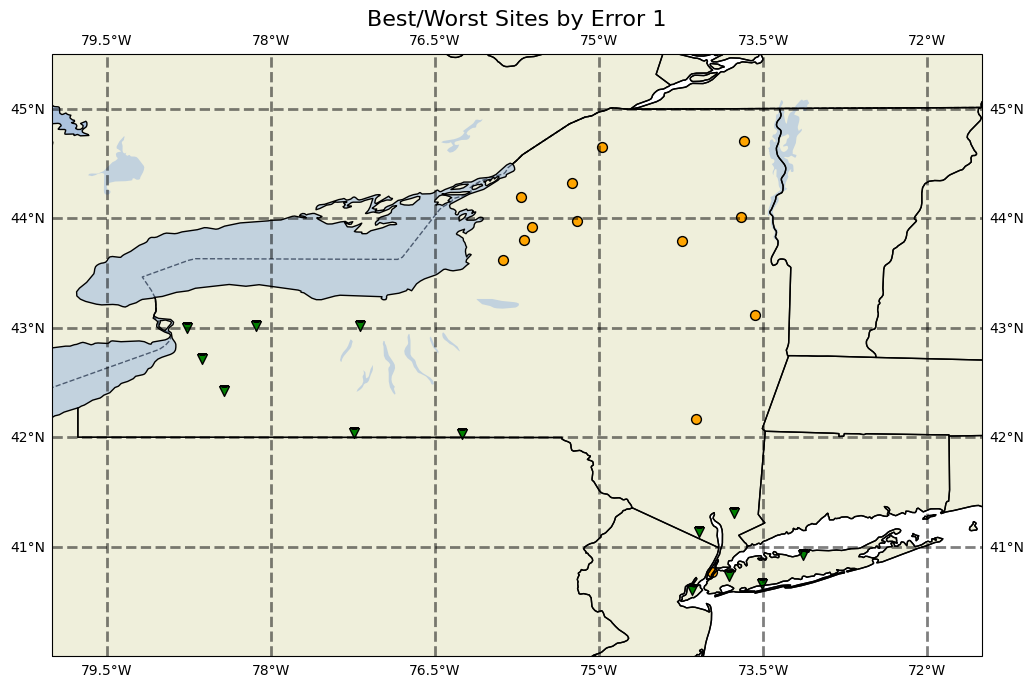

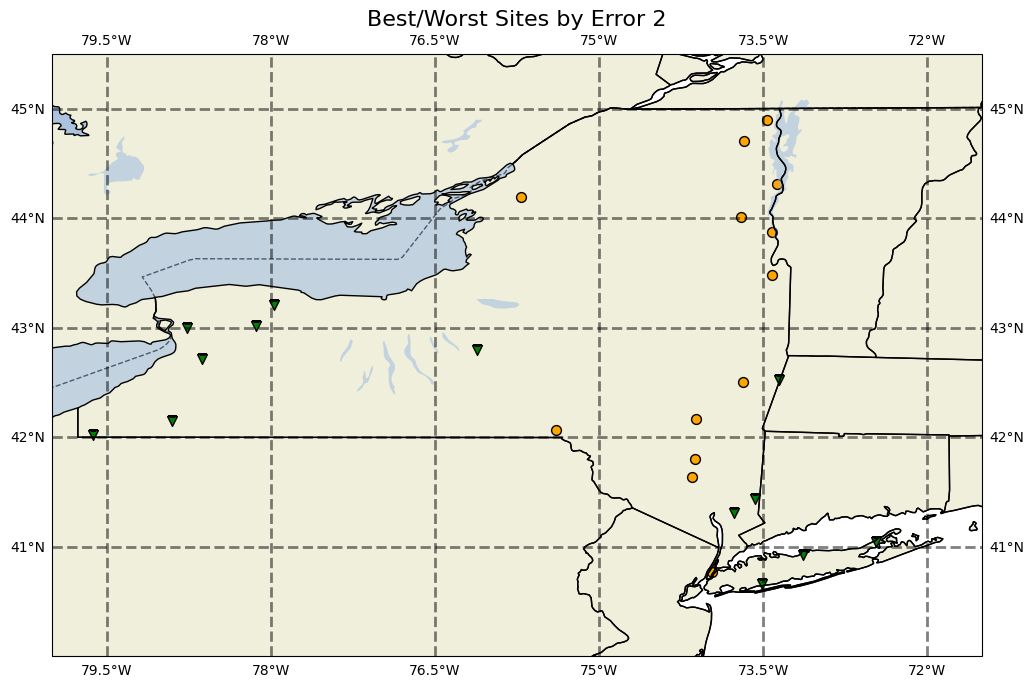

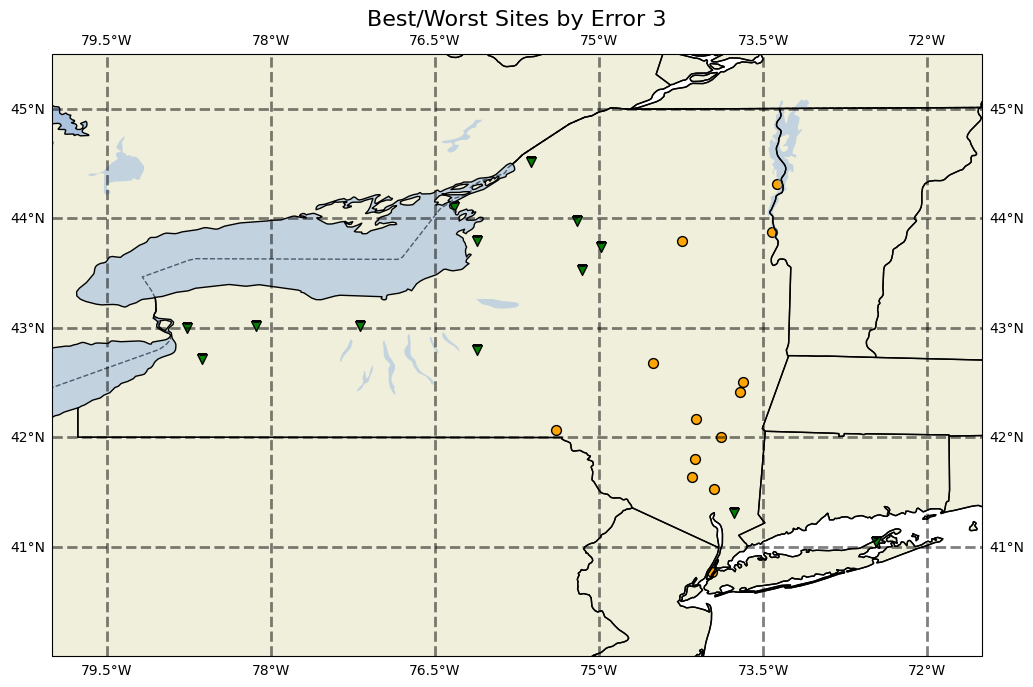

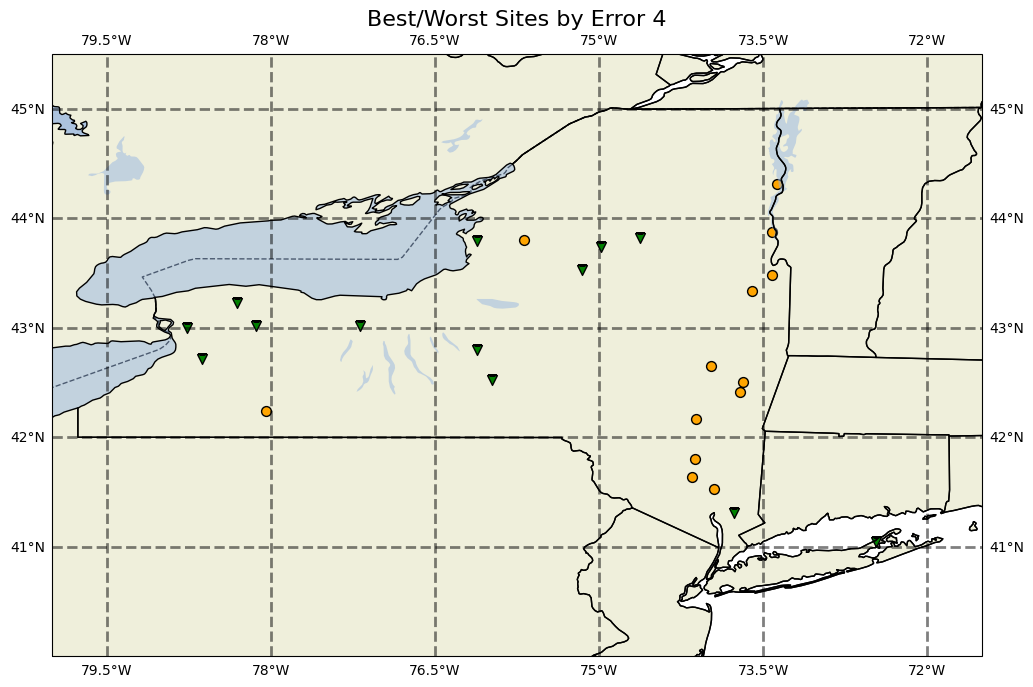

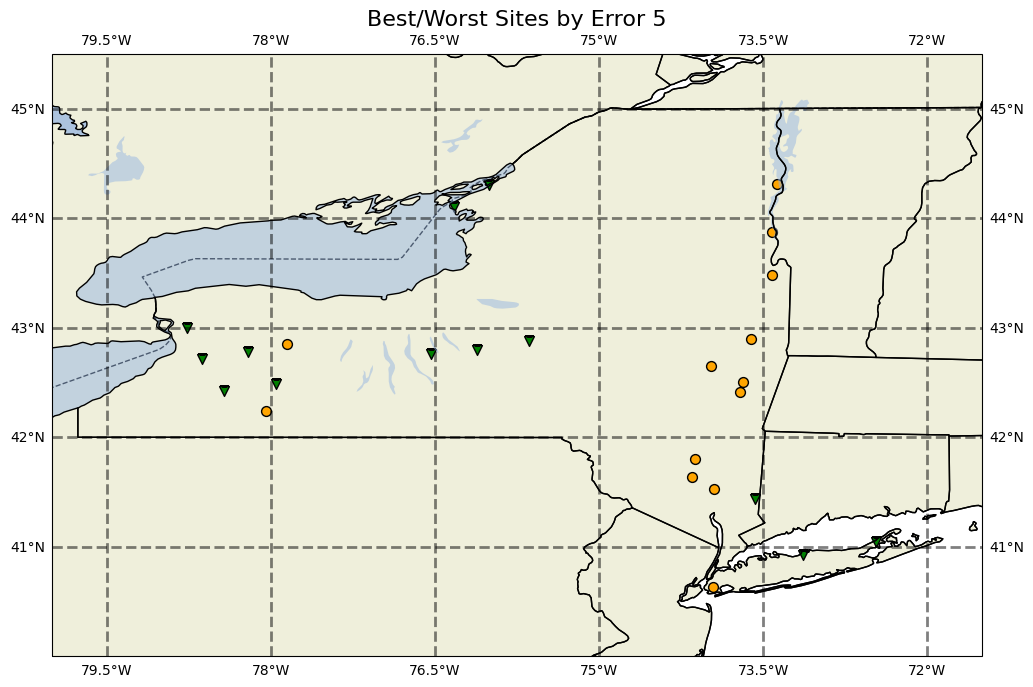

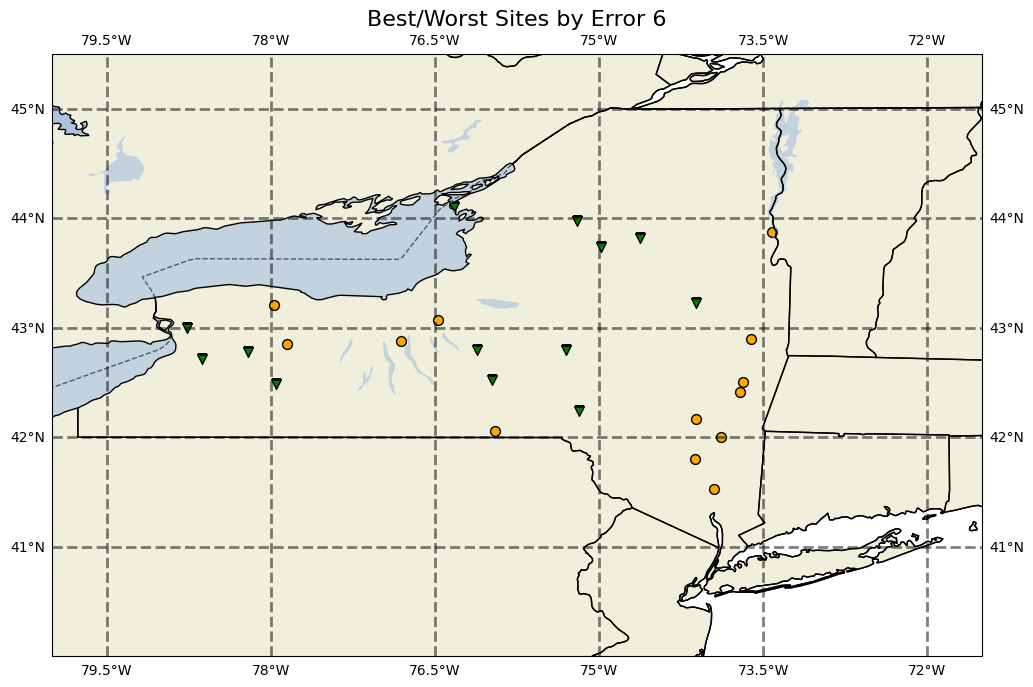

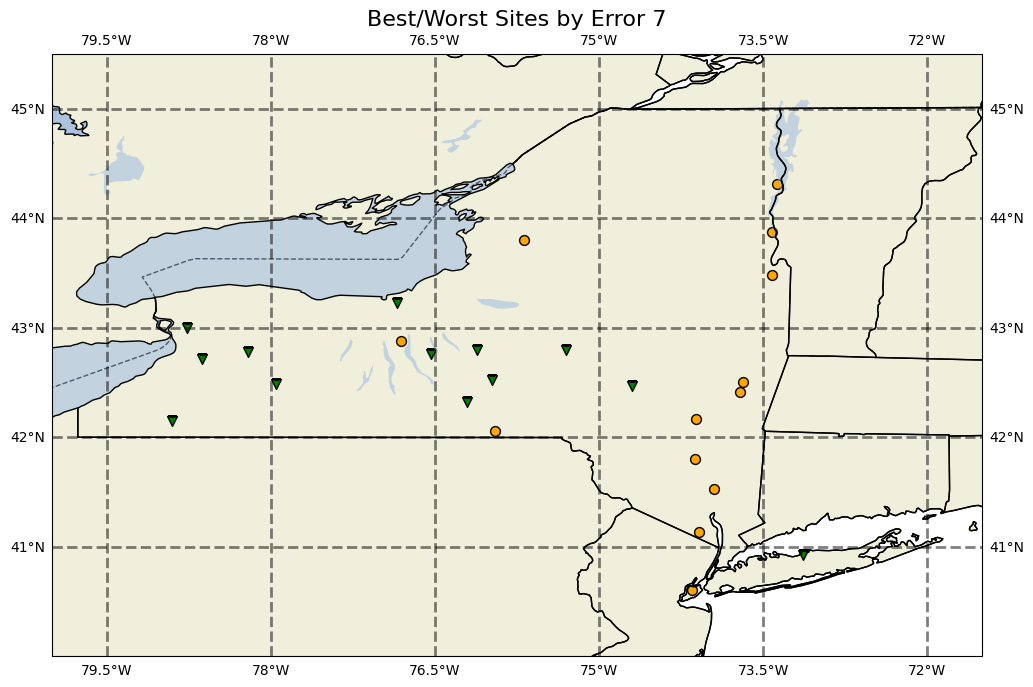

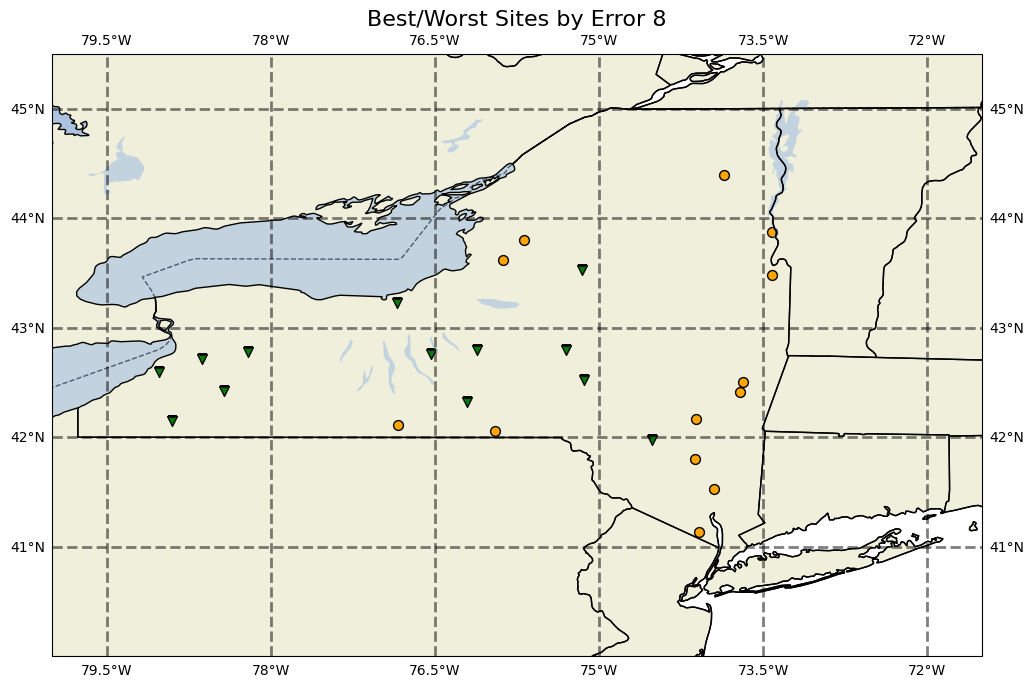

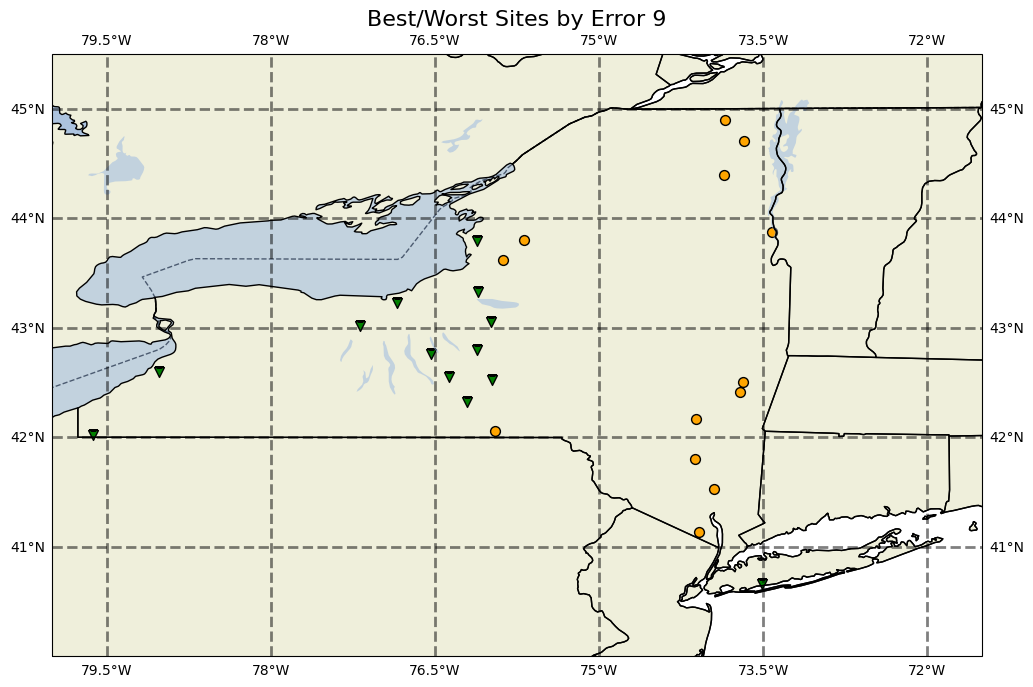

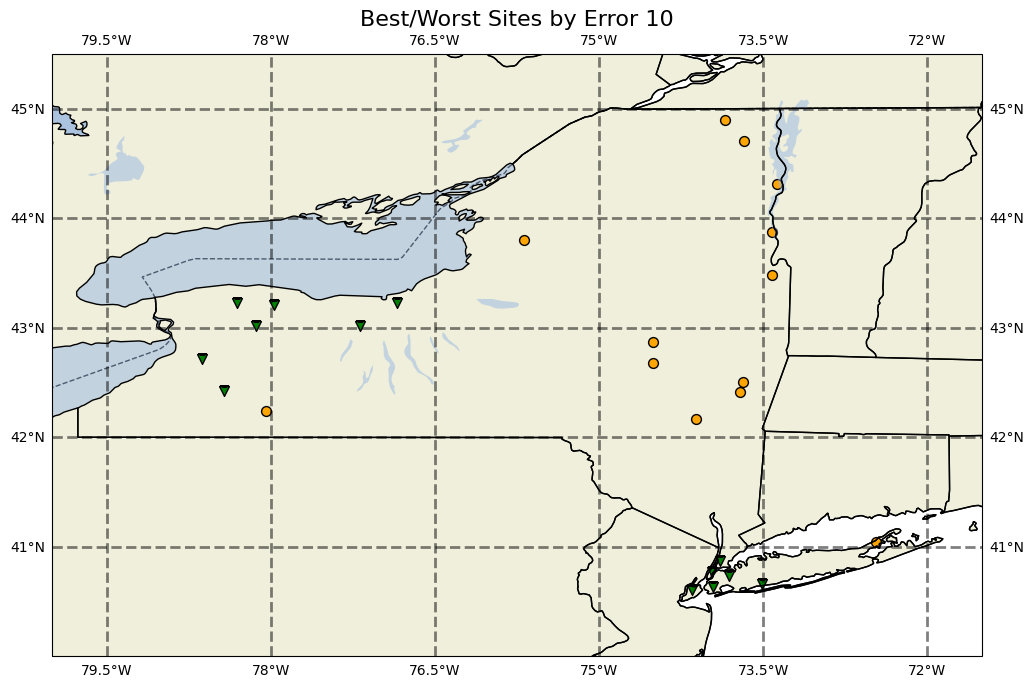

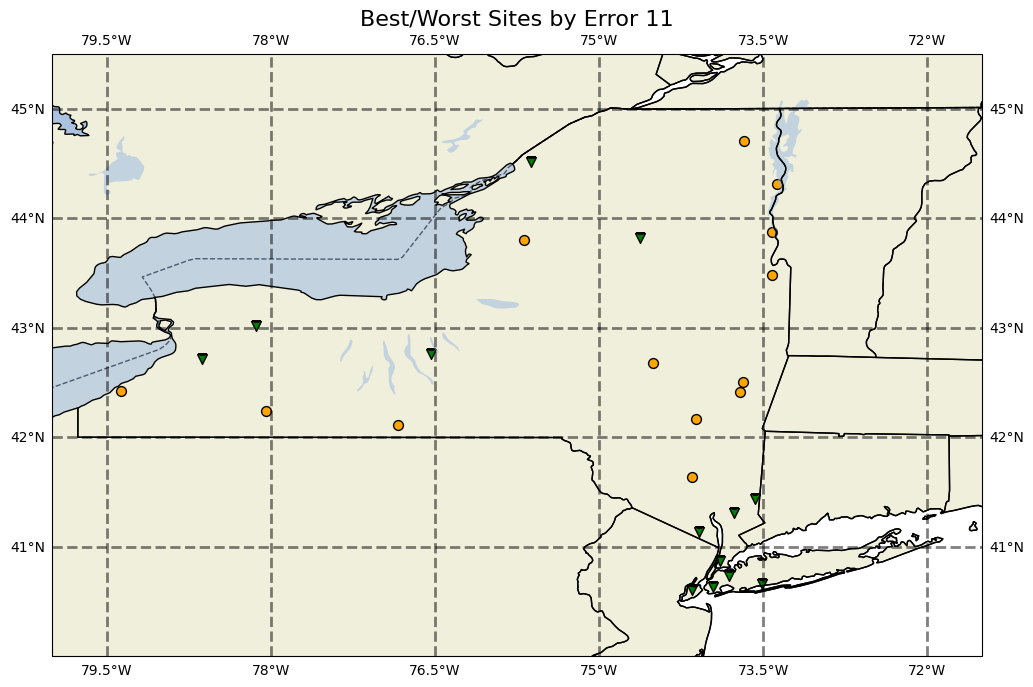

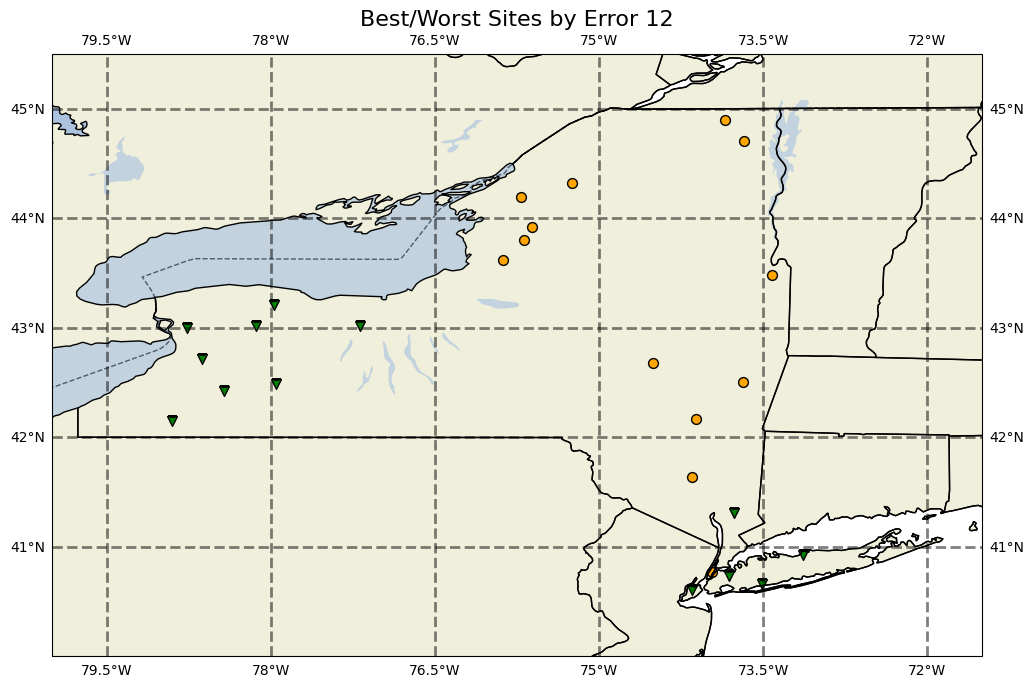

In [37]:
for i in np.arange(1, 13):
    # sort by month
    df_err = rmse_gfs.where(rmse_gfs["time"] == i).dropna()

    # get top and bottom
    top10 = df_err[:13]
    bottom10 = df_err[-13:]
    top10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_gfs.csv"
    )
    bottom10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_gfs.csv"
    )

    # plot
    count_plot(top10, bottom10, i)

In [38]:
tippity_df_gfs = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_gfs.csv"
    )
    tippity_df_gfs = pd.concat([df, tippity_df_gfs])

In [39]:
rockbott_df_gfs = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_gfs.csv"
    )
    rockbott_df_gfs = pd.concat([df, rockbott_df_gfs])

In [40]:
keys = tippity_df_gfs["station"].value_counts()[:13].keys()
keys

Index(['EAUR', 'TULL', 'BUFF', 'BATA', 'SOME', 'WANT', 'CLIF', 'SCIP', 'STON',
       'DELE', 'GROV', 'SOUT', 'WARS'],
      dtype='object')

In [41]:
plot_df_top_gfs = format_plot_df(tippity_df_gfs, keys)

In [42]:
keys = rockbott_df_gfs["station"].value_counts()[:13].keys()
keys

Index(['SCHO', 'TANN', 'TICO', 'KIND', 'WHIT', 'HFAL', 'HARR', 'ESSX', 'BEAC',
       'WALL', 'SARA', 'BING', 'COBL'],
      dtype='object')

In [43]:
plot_df_bott_gfs = format_plot_df(rockbott_df_gfs, keys)

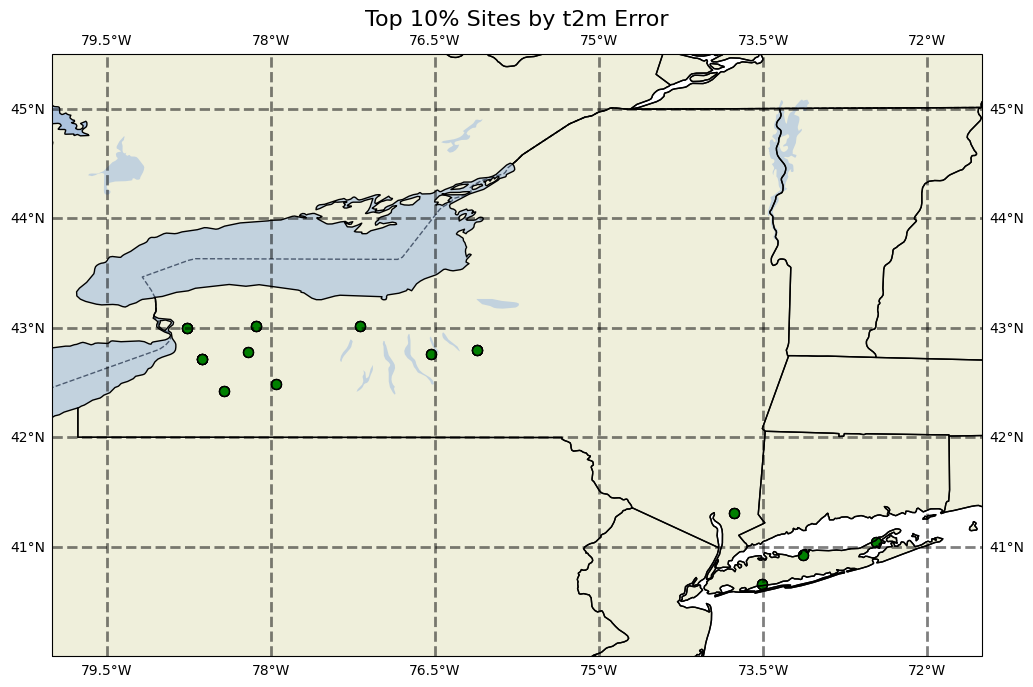

In [44]:
count_plot_top(plot_df_top_gfs)

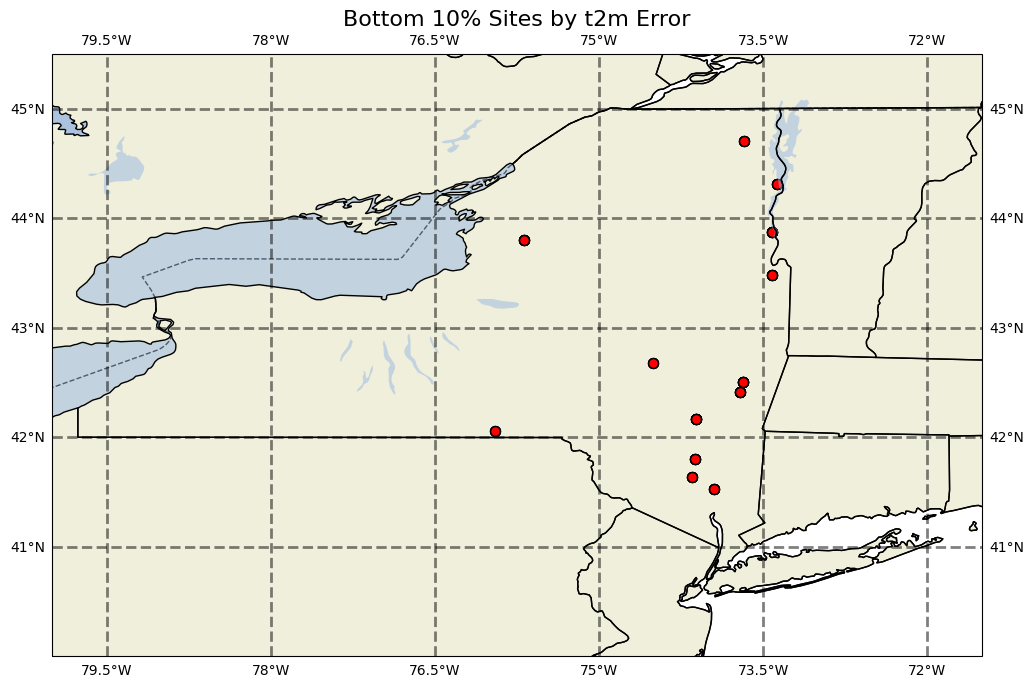

In [45]:
count_plot_bott(plot_df_bott_gfs)

# NAM

In [46]:
rmse_nam = rmse_to_plot[rmse_to_plot["NWP Model"] == "NAM"]
rmse_nam

time station  t2m_error_sq NWP Model        lon        lat
1218    10    QUEE      1.080360       NAM -73.815857  40.734337
104      1    STON      1.112473       NAM -73.131683  40.919121
1092     9    QUEE      1.136234       NAM -73.815857  40.734337
1143    10    BKLN      1.143872       NAM -73.953674  40.631763
1248    10    WANT      1.197500       NAM -73.506157  40.655102
...    ...     ...           ...       ...        ...        ...
32       1    CROG      3.251376       NAM -75.200996  43.974960
40       1    EDWA      3.252593       NAM -75.244133  44.321770
988      8    TANN      3.354067       NAM -74.113426  42.170712
191      2    MANH      3.414395       NAM -73.964485  40.767544
65       1    MANH      3.424378       NAM -73.964485  40.767544

[1512 rows x 6 columns]

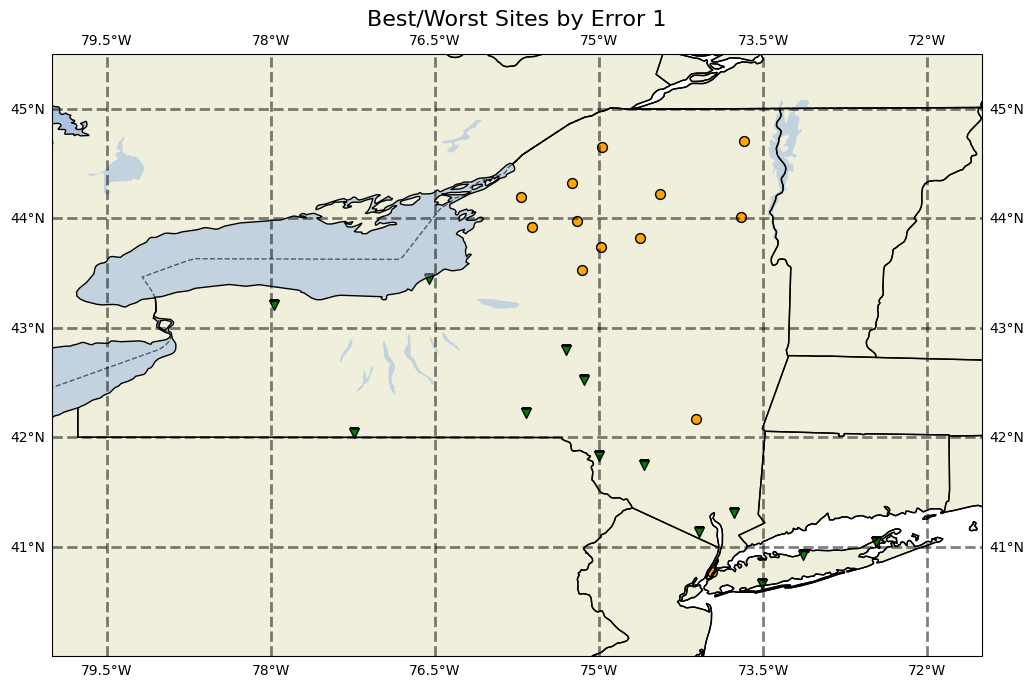

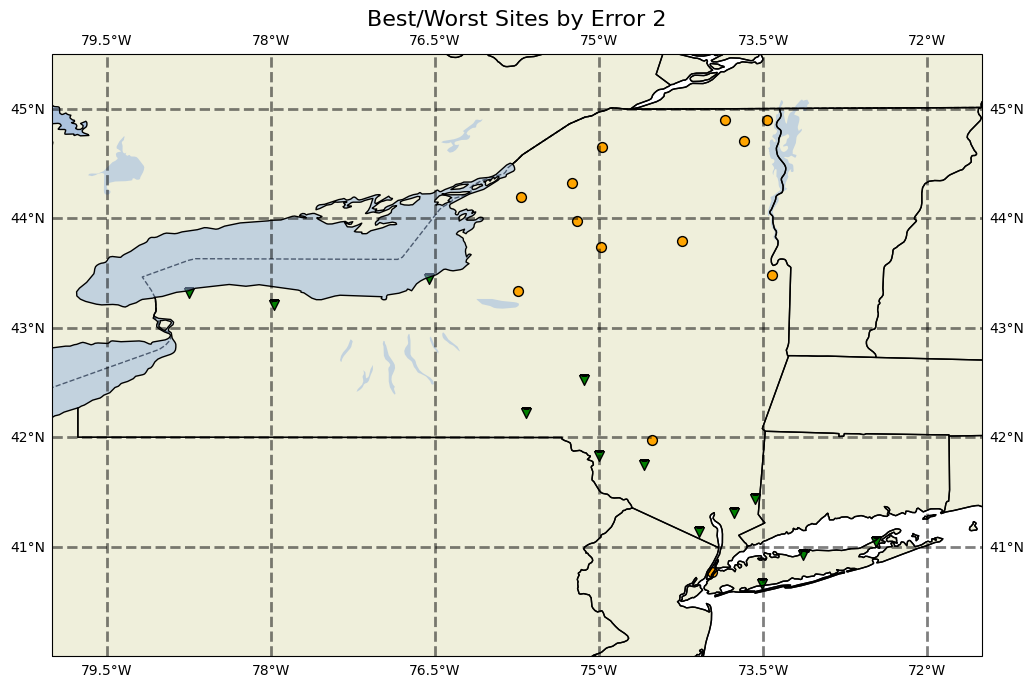

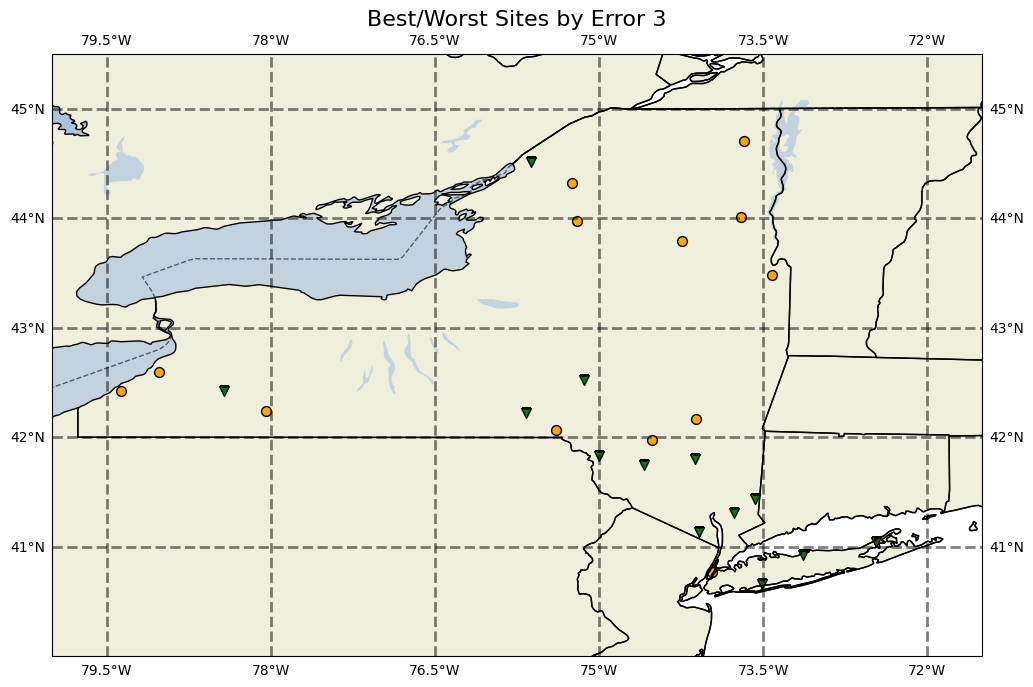

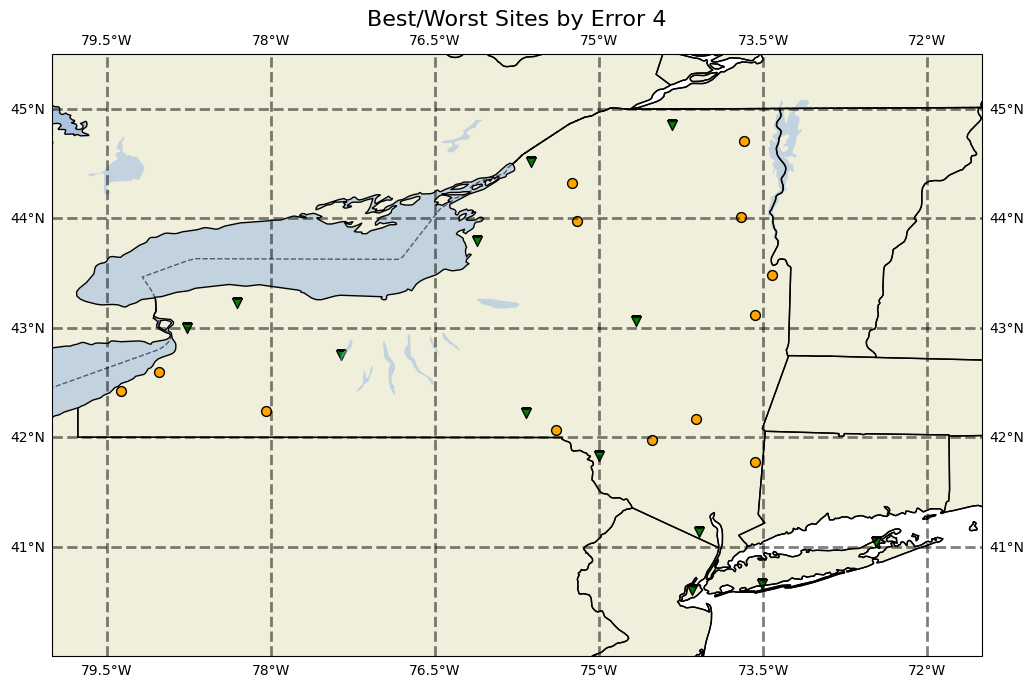

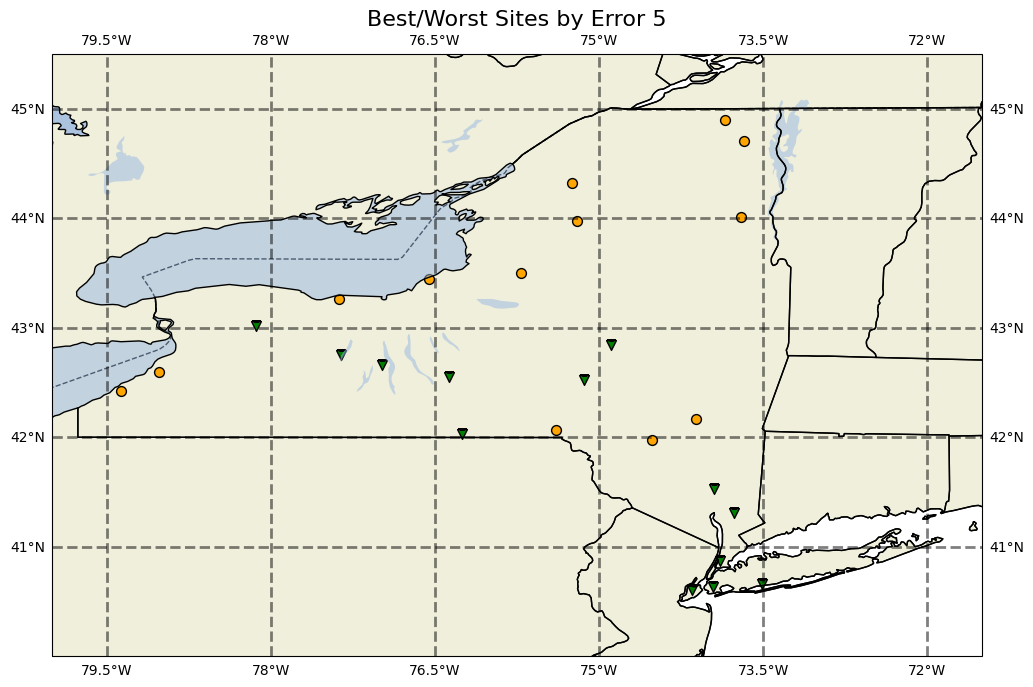

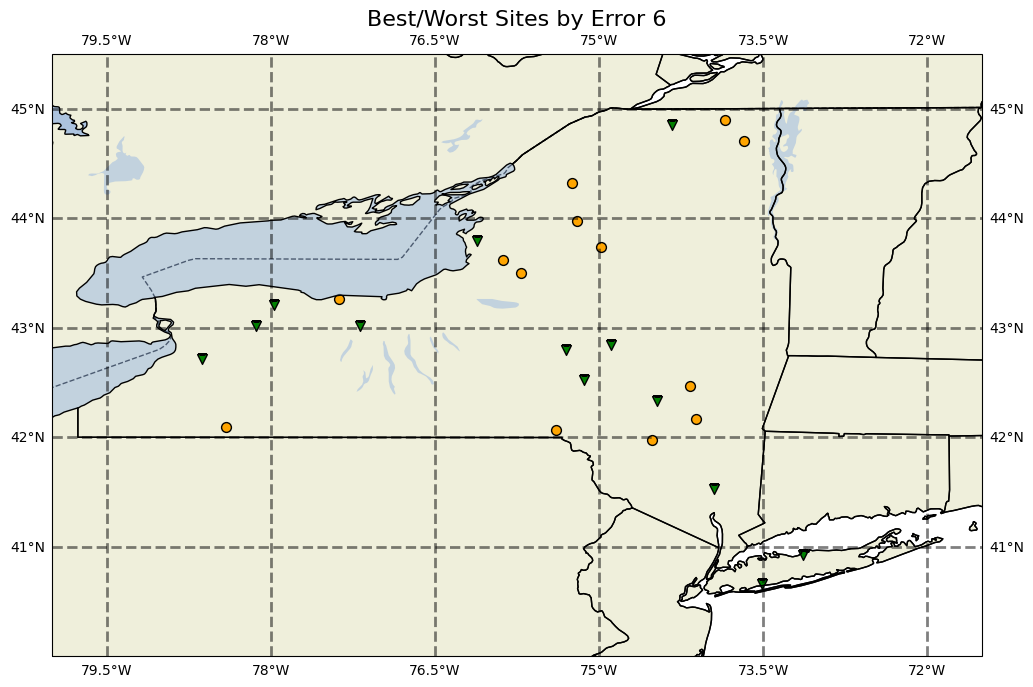

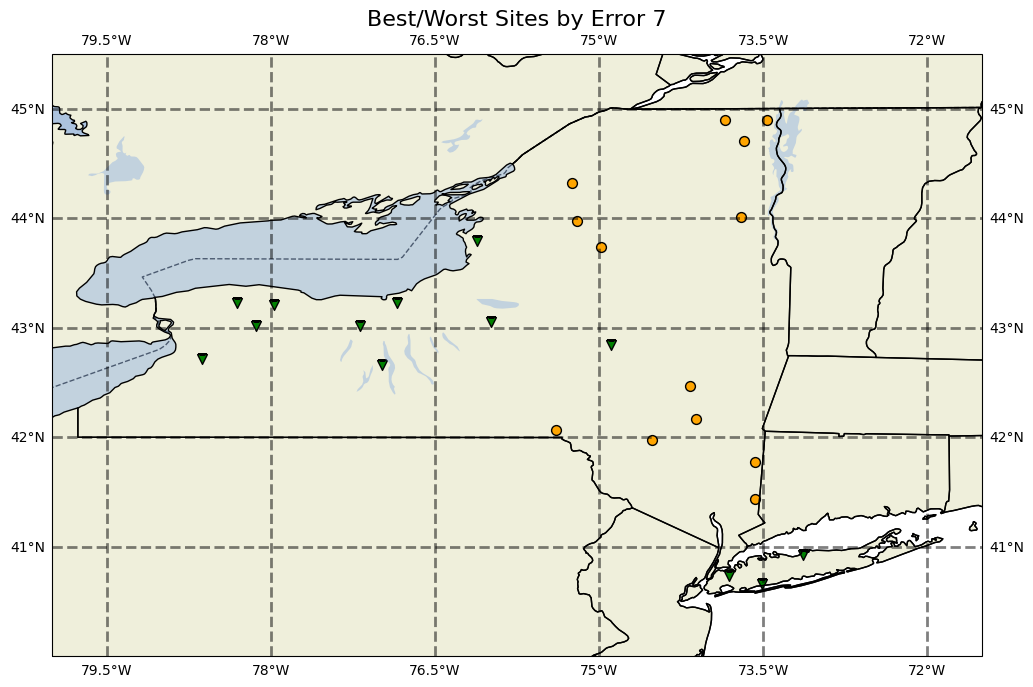

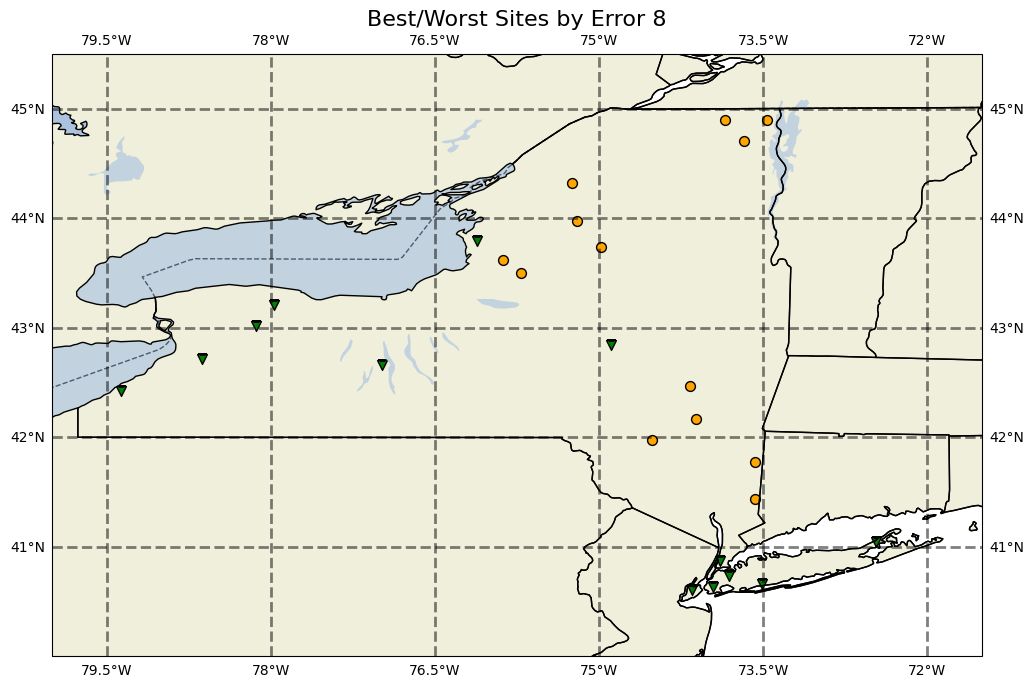

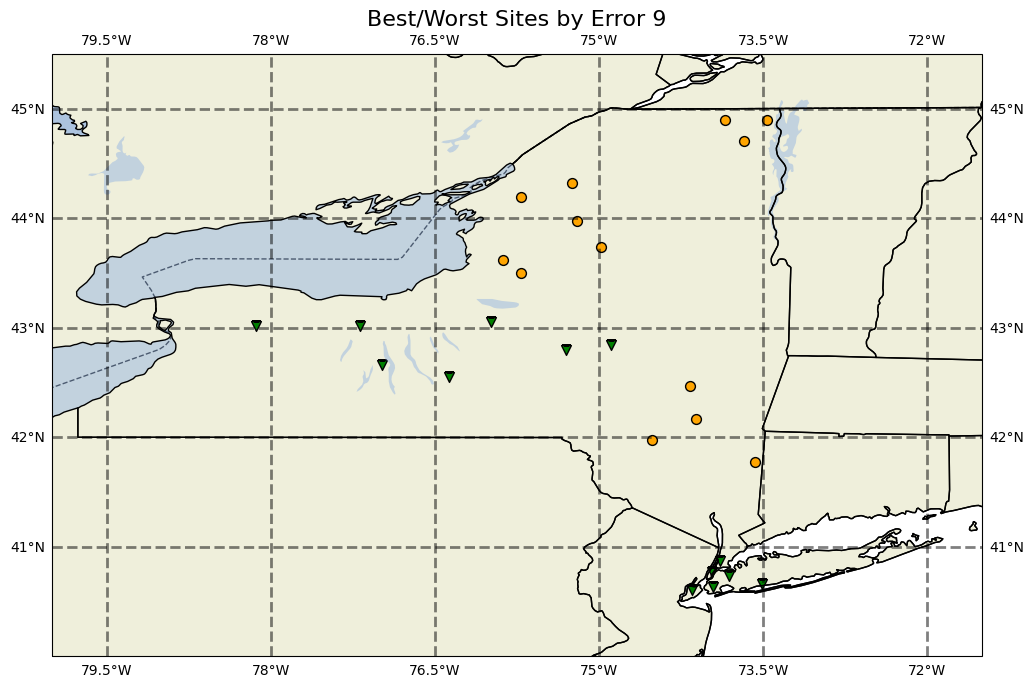

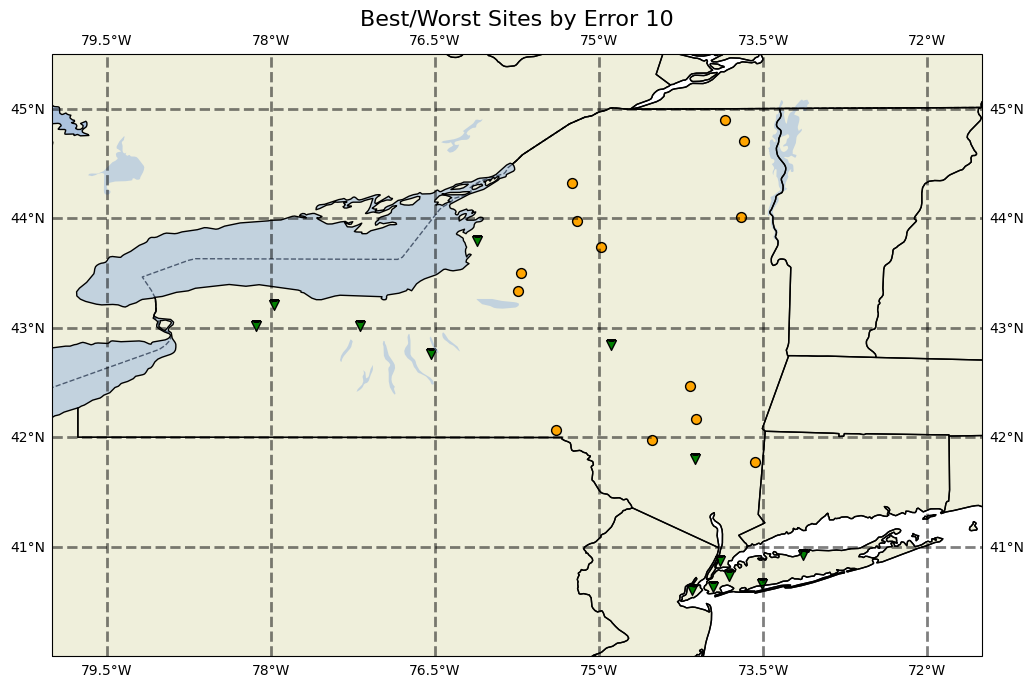

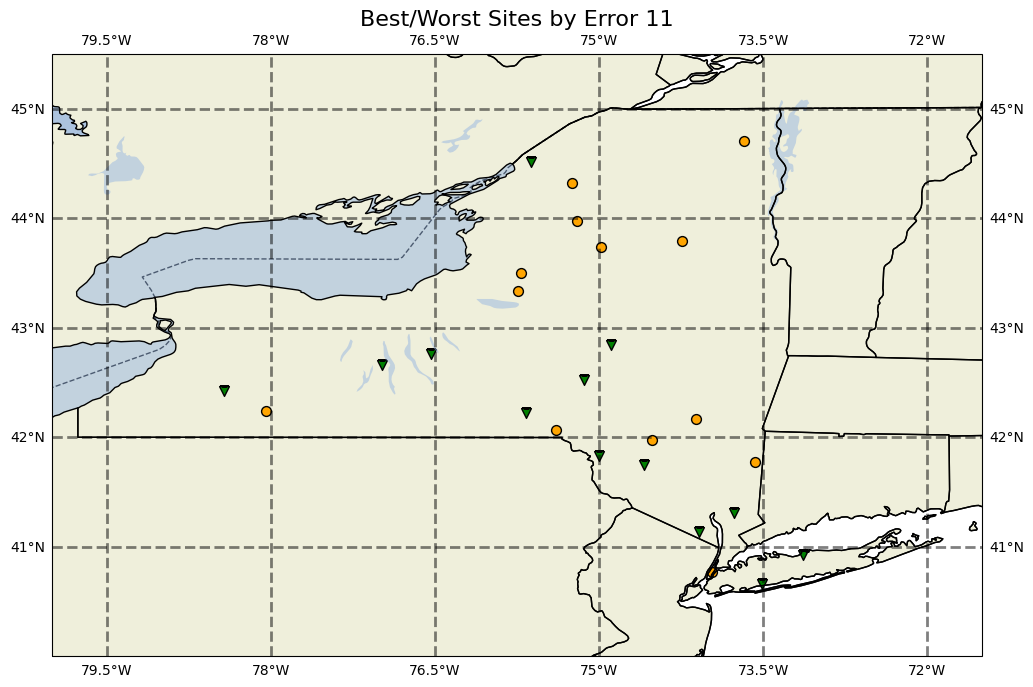

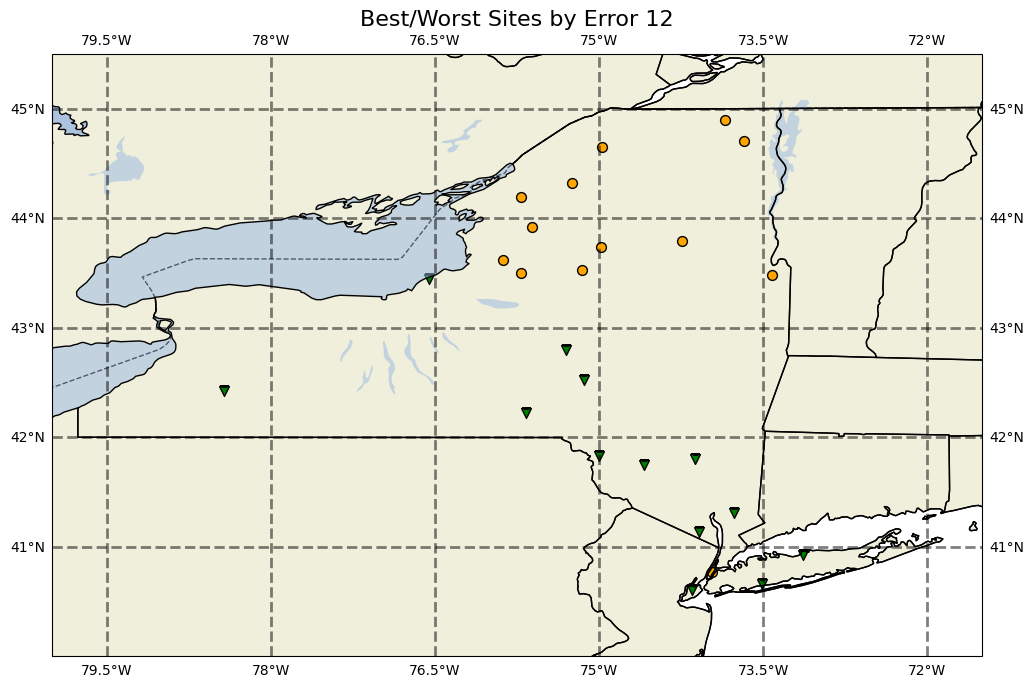

In [47]:
for i in np.arange(1, 13):
    # sort by month
    df_err = rmse_nam.where(rmse_nam["time"] == i).dropna()

    # get top and bottom
    top10 = df_err[:13]
    bottom10 = df_err[-13:]
    top10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_nam.csv"
    )
    bottom10.to_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_nam.csv"
    )

    # plot
    count_plot(top10, bottom10, i)

In [48]:
tippity_df_nam = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/top/t{init}/ny/t{init}z_topcsv_{i}_gfs.csv"
    )
    tippity_df_nam = pd.concat([df, tippity_df_nam])

In [49]:
rockbott_df_nam = pd.DataFrame()
for i in np.arange(1, 13):
    df = pd.read_csv(
        f"/home/aevans/nwp_bias/data/unboxing_df/bottom/t{init}/ny/t{init}z_bottcsv_{i}_gfs.csv"
    )
    rockbott_df_nam = pd.concat([df, rockbott_df_nam])

In [50]:
keys = tippity_df_nam["station"].value_counts()[:13].keys()
keys

Index(['EAUR', 'TULL', 'BUFF', 'BATA', 'SOME', 'WANT', 'CLIF', 'SCIP', 'STON',
       'DELE', 'GROV', 'SOUT', 'WARS'],
      dtype='object')

In [51]:
plot_df_top_nam = format_plot_df(tippity_df_nam, keys)

In [52]:
keys = rockbott_df_nam["station"].value_counts()[:13].keys()
keys

Index(['SCHO', 'TANN', 'TICO', 'KIND', 'WHIT', 'HFAL', 'HARR', 'ESSX', 'BEAC',
       'WALL', 'SARA', 'BING', 'COBL'],
      dtype='object')

In [53]:
plot_df_bott_nam = format_plot_df(rockbott_df_nam, keys)

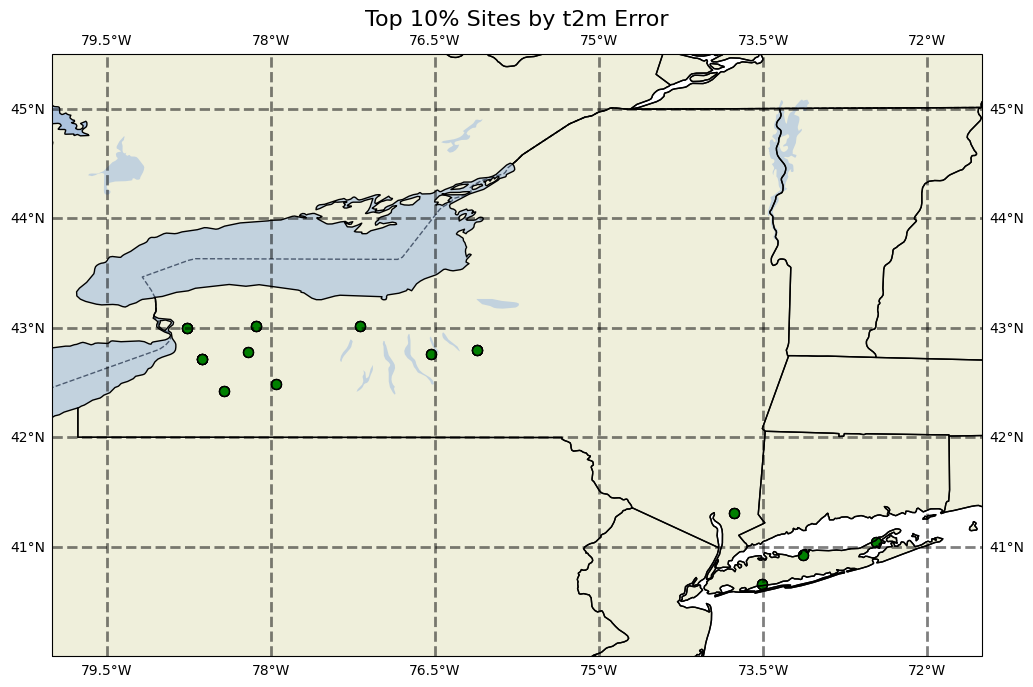

In [54]:
count_plot_top(plot_df_top_nam)

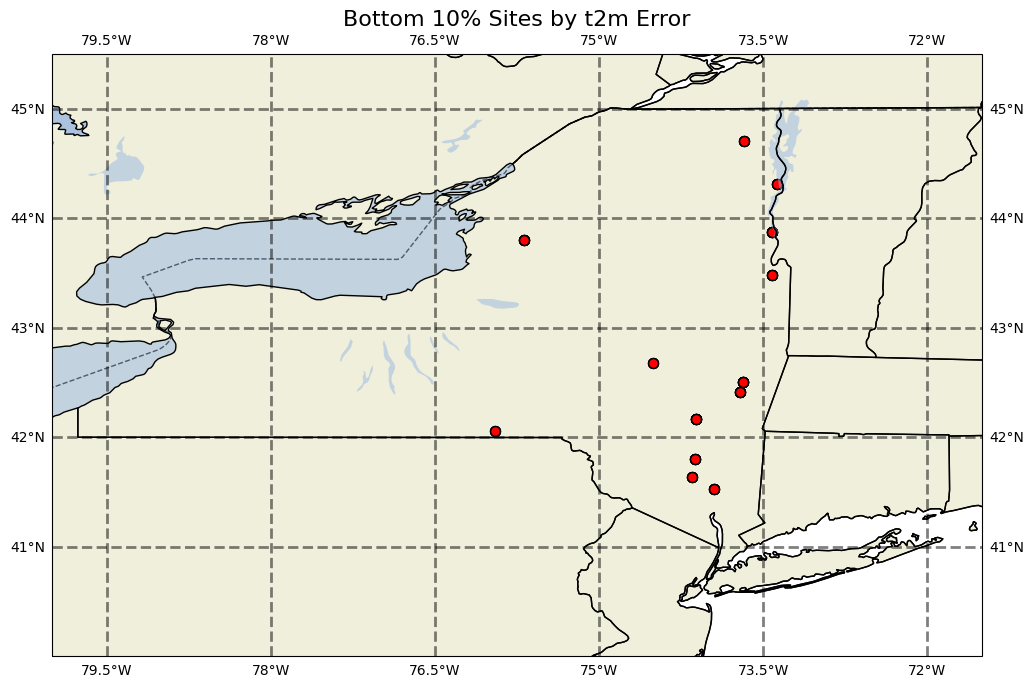

In [55]:
count_plot_bott(plot_df_bott_nam)

# Least Error

In [56]:
tops = pd.DataFrame()
tops = pd.concat([tippity_df, tops])
tops = pd.concat([tippity_df_gfs, tops])
tops = pd.concat([tippity_df_nam, tops])

In [57]:
tops.head()

Unnamed: 0  time station  t2m_error_sq NWP Model        lon        lat
0        1500  12.0    WANT      1.307309       GFS -73.506157  40.655102
1        1388  12.0    BATA      1.317799       GFS -78.135658  43.019939
2        1420  12.0    DELE      1.342007       GFS -78.423203  42.418465
3        1402  12.0    BUFF      1.349958       GFS -78.767174  43.000172
4        1411  12.0    CLIF      1.350521       GFS -77.185181  43.014790

In [58]:
top_keys = tops["station"].value_counts()[:13].keys()
top_keys

Index(['EAUR', 'BUFF', 'SCIP', 'SOUT', 'SOME', 'STON', 'BROC', 'BATA', 'DELE',
       'TULL', 'STAT', 'GROV', 'CLIF'],
      dtype='object')

In [59]:
plot_df_tops = format_plot_df(tops, keys)

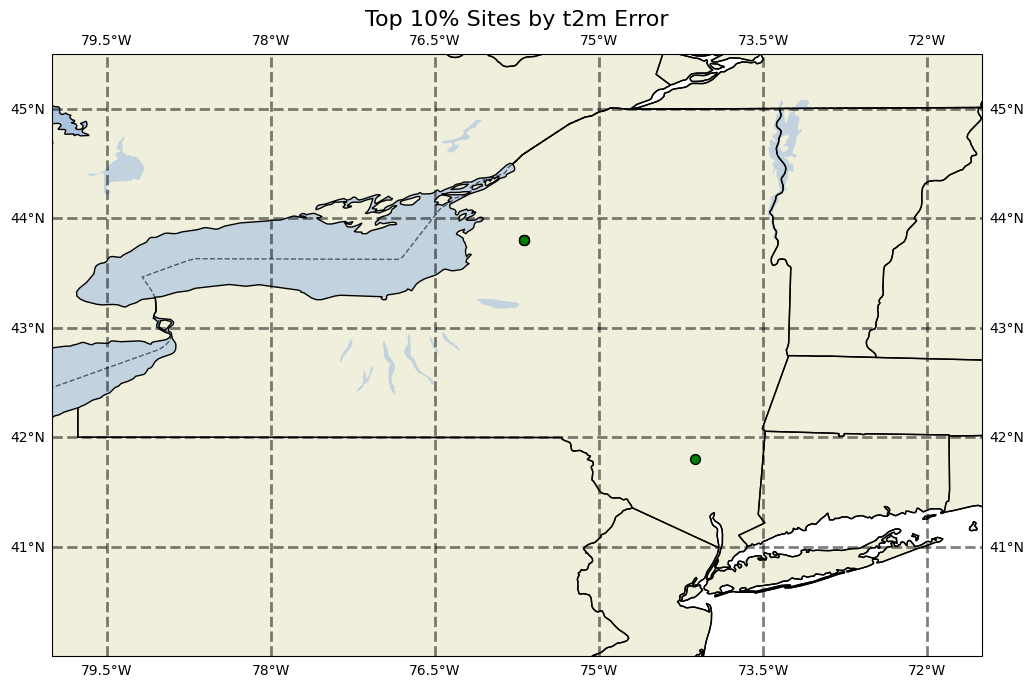

In [60]:
count_plot_top(plot_df_tops)

# Most Error

In [61]:
botts = pd.DataFrame()
botts = pd.concat([rockbott_df, botts])
botts = pd.concat([rockbott_df_gfs, botts])
botts = pd.concat([rockbott_df_nam, botts])

In [62]:
keys = botts["station"].value_counts()[:13].keys()
keys

Index(['TANN', 'TICO', 'WHIT', 'SCHO', 'WALL', 'KIND', 'SARA', 'HARR', 'HFAL',
       'YORK', 'ESSX', 'BEAC', 'MANH'],
      dtype='object')

In [63]:
plot_df_botts = format_plot_df(botts, keys)

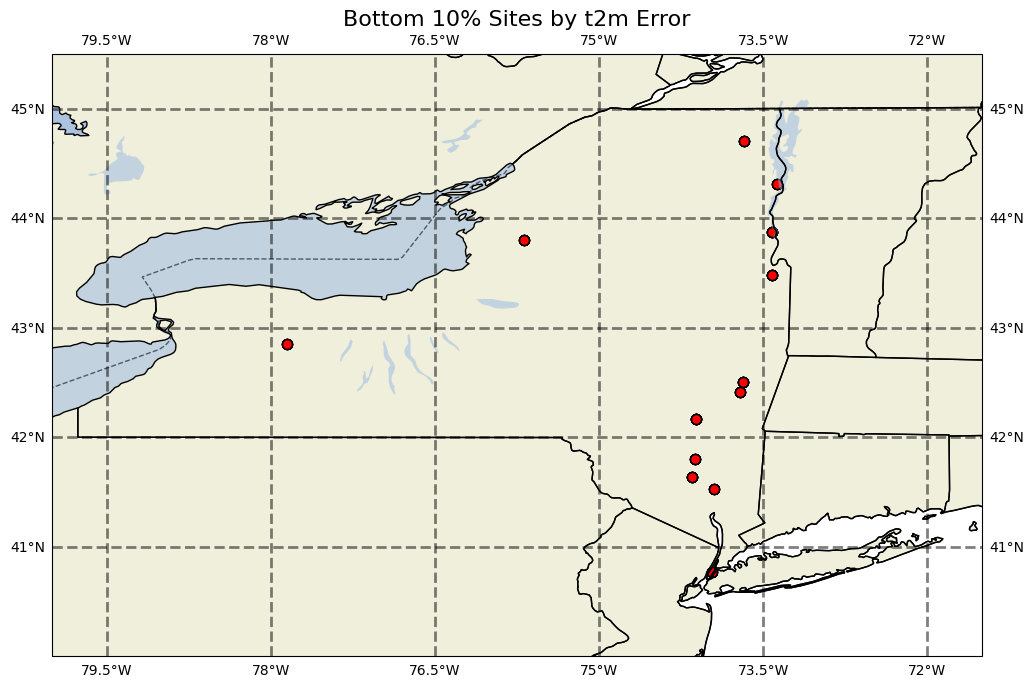

In [64]:
count_plot_bott(plot_df_botts)

In [65]:
bott_bott = get_monthly_rmse_data(18, "t2m_error")
bott_bott = bott_bott[bott_bott["station"].isin(keys)]

GFS 1.9642531135956658
NAM 1.8713559231397245
HRRR 2.1093853


In [66]:
top_top = get_monthly_rmse_data(18, "t2m_error")
top_top = top_top[top_top["station"].isin(top_keys)]

GFS 1.9642531135956658
NAM 1.8713559231397245
HRRR 2.1093853


In [67]:
bott_bott

time station  t2m_error_sq NWP Model
3        1    BEAC      2.007262       GFS
44       1    ESSX      2.306691       GFS
54       1    HARR      2.674249       GFS
57       1    HFAL      2.041230       GFS
61       1    KIND      2.174841       GFS
...    ...     ...           ...       ...
1492    12    TANN      2.189540      HRRR
1493    12    TICO      2.471293      HRRR
1498    12    WALL      2.676454      HRRR
1509    12    WHIT      2.952578      HRRR
1511    12    YORK      2.727689      HRRR

[468 rows x 4 columns]

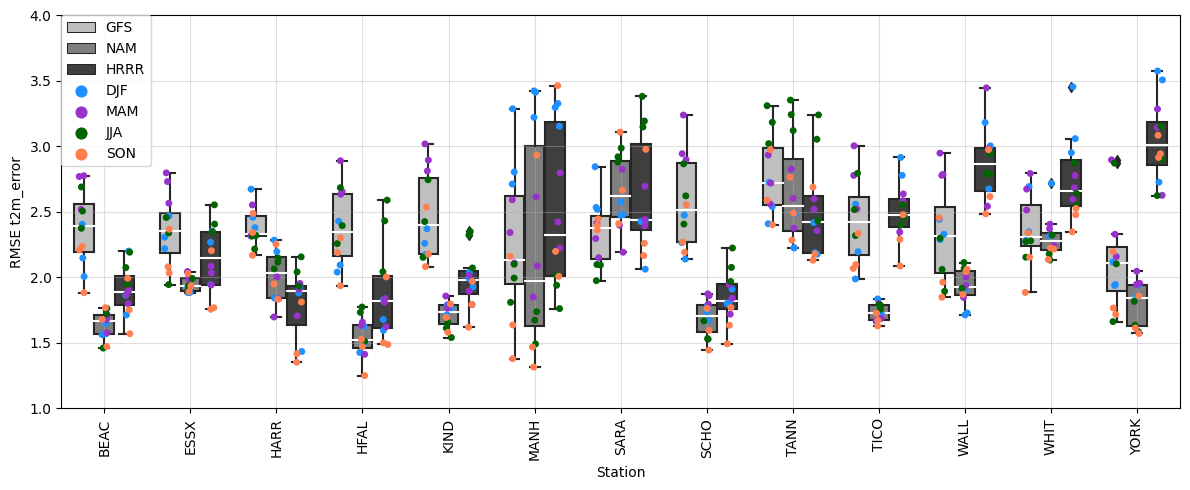

In [68]:
plot_rmse_boxplots(bott_bott, 18, "t2m_error")

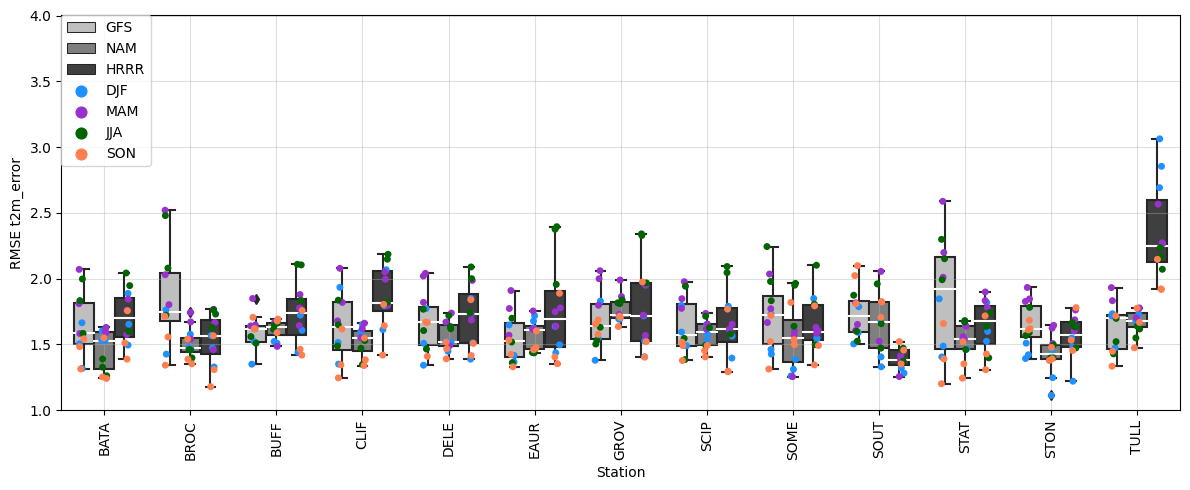

In [69]:
plot_rmse_boxplots(top_top, 18, "t2m_error")

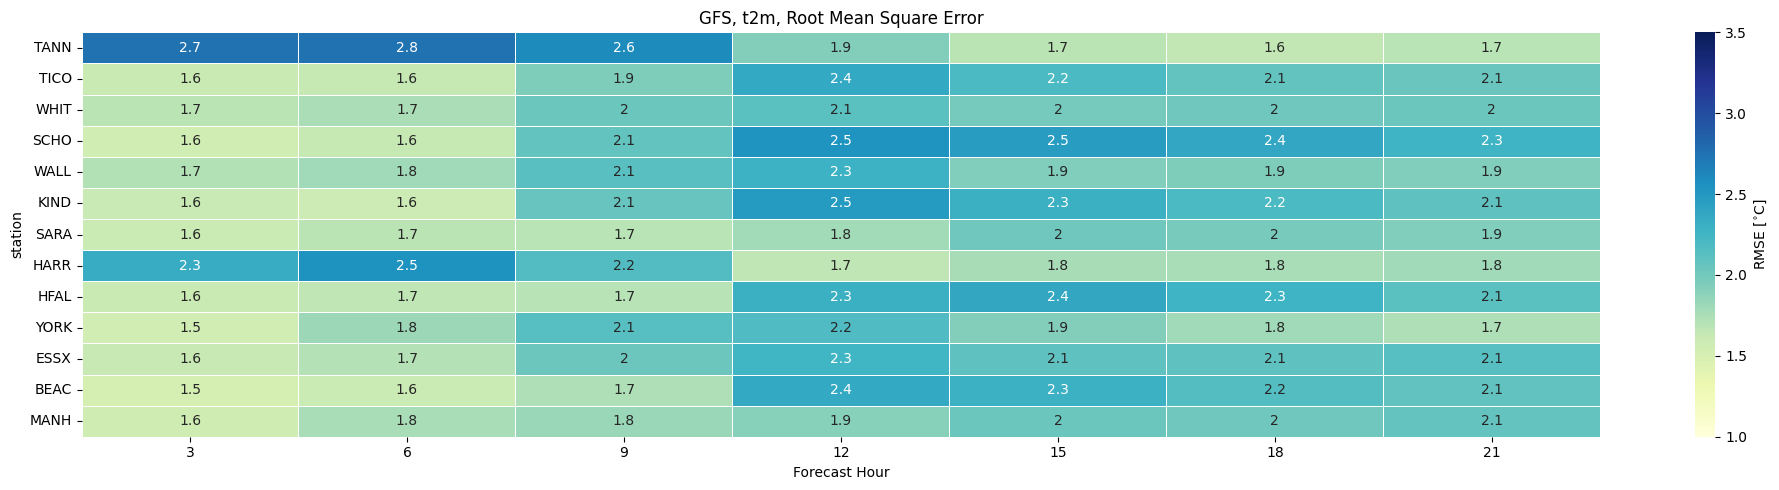

In [74]:
var = "t2m_error"
units = "$^{\circ}$C"
plot_model_rmse_heatmap_fhours_clim_divs(
    "GFS", gfs_fcast_and_error_df, var, units, var_val_range.get(var), keys
)

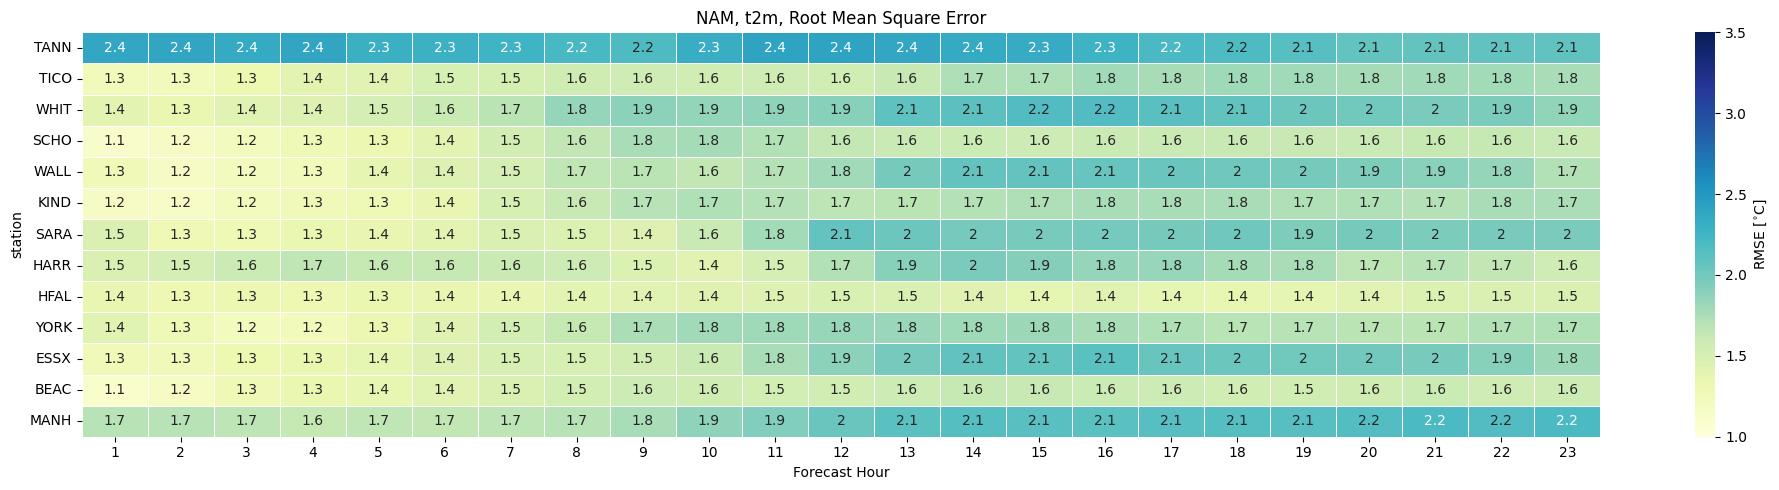

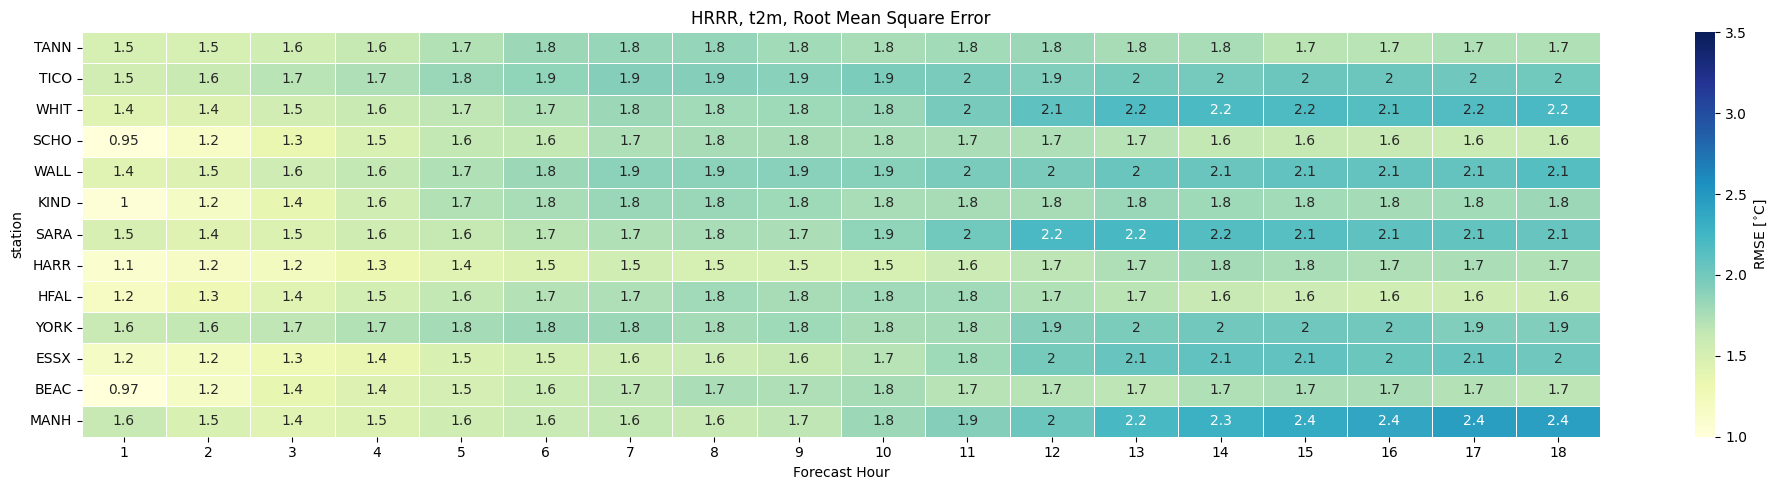

In [75]:
plot_model_rmse_heatmap_fhours_clim_divs(
    "NAM", nam_fcast_and_error_df, var, units, var_val_range.get(var), keys
)
plot_model_rmse_heatmap_fhours_clim_divs(
    "HRRR", hrrr_fcast_and_error_df, var, units, var_val_range.get(var), keys
)